# Ising Model Project



### University of Notre Dame 
### Students: 
* Bryan Piguave
* Thomas Burton 


# Question A 

Show that your random number generator is reliable. That is, does it yield independent, identically distributed random variables, uniformly distributed in the interval [0,1]

# Answer to Question A

Average of random numbers: 0.49985742875852957
Standard deviation of random numbers: 0.2891811941962008
Relative error: 0.03%


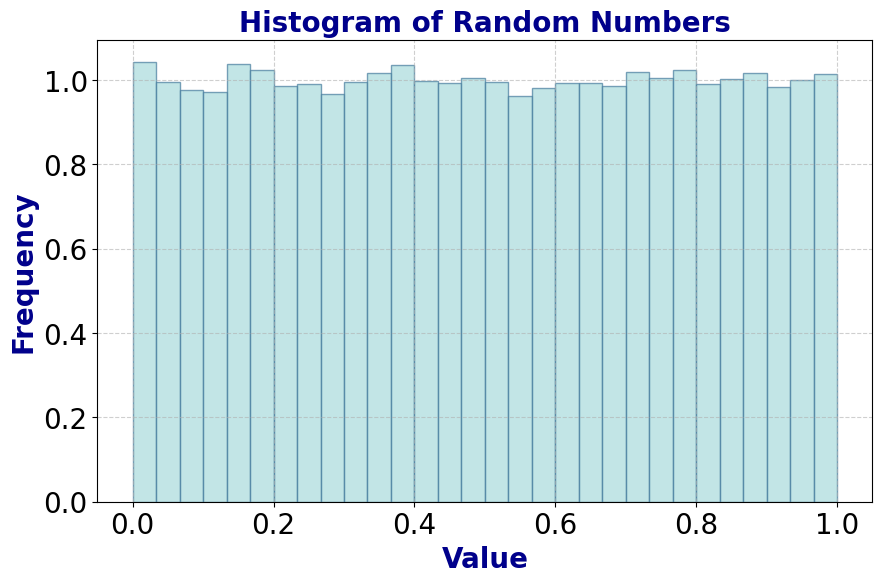

In [16]:
import numpy as np
import matplotlib.pyplot as plt

font_dict = {'family': 'sans-serif', 'color': 'darkblue', 'weight': 'bold', 'size': 20}

def main():
    # Generate 100000 random numbers between 0 and 1
    random_numbers = np.random.rand(100000)
    plt.figure(figsize=(10, 6))
    plt.hist(random_numbers, bins=30, density=True, alpha=0.7, color='#a8dadc', edgecolor='#457b9d')
    plt.title('Histogram of Random Numbers', fontdict=font_dict)
    plt.xlabel('Value', fontdict=font_dict)
    plt.ylabel('Frequency', fontdict=font_dict)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.savefig('random_numbers_histogram_soft.png')

    # Average of the random numbers
    average = np.mean(random_numbers)
    print(f"Average of random numbers: {average}")
    # Standard deviation of the random numbers
    std_dev = np.std(random_numbers)
    print(f"Standard deviation of random numbers: {std_dev}")

    # Relative error compared to the expected value of 0.5
    relative_error = 100 * abs(average - 0.5) / 0.5
    print(f"Relative error: {relative_error:.2f}%")

    return 0


if __name__ == "__main__":
    main()

# Question B

Write a code for the 2 dimensional Ising model, with H = 0. Explain briefly the Monte Carlo method. Explain the main ideas of the code, the clever ideas that save computation time, etc. Discuss briefly the expected effects of boundary conditions. What boundary conditions did you choose?

# Answer to question B

### Ising2D class

For this project, we created a class called Ising 2D. We initialize the model using an LxL lattice. Therefore, the model object starts with the following attributes:
* L : Linear size of the square lattice 
* Initial_state: a string value that allows us to choose how we would like the spins to be oriented at the beginning (all up, all down or random)
* H: External magnetic field strength 
* J: Interaction magnetic field strength 
The class Ising2D contains several methods to calculate the energy, magnetization, 
and the Monte Carlo Step to run the simulation.


We use the periodic boundary conditions to solve this problem. 
In the function, get_neighbors_sum_numba(), we use the modulus operator to emulate that condition. 

get_neighbors_sum_numba: Calculates the sum of neighboring spins.
calculate_delta_E_numba: Calculates the energy change upon flipping a spin.
monte_carlo_step_numba: Performs the core Metropolis algorithm steps.
calculate_energy_numba: Calculates the total energy of the lattice.
calculate_magnetization_numba: Calculates the total magnetization.

### Computational improvements 
To make Python code faster, we decided to use the numba library which basically, compiles Python functions directly to efficent machine code, bypassing th Python interpreter's overhead.
Inside the Numba-compiled monte_carlo_step_numba, we use random.randrange(L) instead of np.random.randint(L) for generating random indices. 
For single integer generation within a loop, the built-in random module can be faster within a Numba-compiled function.


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import numba

@numba.jit(nopython=True)
def get_neighbors_sum_numba(lattice, L, i, j):
    """
    Numba-optimized function to calculate the sum of the nearest neighbor spins
    for site (i, j) using periodic boundary conditions.
    """
    top = lattice[(i - 1) % L, j]
    bottom = lattice[(i + 1) % L, j]
    left = lattice[i, (j - 1) % L]
    right = lattice[i, (j + 1) % L]
    return top + bottom + left + right

@numba.jit(nopython=True)
def calculate_delta_E_numba(lattice, L, J, H, i, j):
    """
    Numba-optimized function to calculate the change in energy if the spin
    at (i, j) is flipped.
    ΔE = 2 * s_ij * (J * sum_neighbors + H)
    """
    spin_ij = lattice[i, j]
    neighbors_sum = get_neighbors_sum_numba(lattice, L, i, j)
    delta_E = 2 * spin_ij * (J * neighbors_sum + H)
    return delta_E

@numba.jit(nopython=True)
def monte_carlo_step_numba(lattice, L, N, J, H, beta):
    """
    Numba-optimized function for one Monte Carlo step using the Metropolis algorithm.
    One step consists of N attempted spin flips (where N = L*L).
    """
    for _ in range(N):
        # 1. Choose a random spin site
        i = random.randrange(L)
        j = random.randrange(L)

        # 2. Calculate the energy change if this spin is flipped
        delta_E = calculate_delta_E_numba(lattice, L, J, H, i, j)

        # 3. Metropolis acceptance criterion
        if delta_E < 0 or random.random() < np.exp(-delta_E * beta):
            lattice[i, j] *= -1 # Flip the spin
    return lattice

@numba.jit(nopython=True)
def calculate_energy_numba(lattice, L, J, H):
    """
    Numba-optimized function to calculate the total energy of the lattice.
    E = -J Σ_<i,j> s_i s_j - H Σ_i s_i
    The sum Σ_<i,j> is over nearest neighbor pairs (each pair counted once).
    """
    energy = 0.0
    for i in range(L):
        for j in range(L):
            spin_ij = lattice[i, j]
            neighbor_sum = lattice[i, (j + 1) % L] + lattice[(i + 1) % L, j]
            energy += -J * spin_ij * neighbor_sum
            energy += -H * spin_ij
    return energy

@numba.jit(nopython=True)
def calculate_magnetization_numba(lattice):
    """
    Numba-optimized function to calculate the total magnetization of the lattice.
    M = Σ_i s_i
    """
    return np.sum(lattice)

class Ising2D:
    """
    Implements a 2D Ising model simulation using the Metropolis Monte Carlo algorithm.
    Optimized with Numba for speed.
    """
    def __init__(self, L, initial_state='random', J=1.0, H=0.0):
        """
        Initializes the Ising model on an LxL lattice.

        Args:
            L (int): Linear size of the square lattice.
            initial_state (str): 'random' for random initial spins, 'up' for all spins +1,
                                    'down' for all spins -1.
            J (float): Interaction strength (J > 0 for ferromagnetic).
            H (float): External magnetic field strength.
        """
        self.L = L
        self.N = L * L  # Total number of spins
        self.J = J
        self.H = H

        if initial_state == 'random':
            self.lattice = np.random.choice([1, -1], size=(L, L))
        elif initial_state == 'up':
            self.lattice = np.ones((L, L), dtype=np.int8)
        elif initial_state == 'down':
            self.lattice = -np.ones((L, L), dtype=np.int8)
        else:
            raise ValueError("initial_state must be 'random', 'up', or 'down'")

    def monte_carlo_step(self, beta):
        """
        Performs one Monte Carlo step using the Metropolis algorithm, optimized with Numba.
        One step consists of N attempted spin flips (where N = L*L).

        Args:
            beta (float): Inverse temperature (1 / (k_B * T)). k_B is assumed to be 1.
        """
        self.lattice = monte_carlo_step_numba(self.lattice, self.L, self.N, self.J, self.H, beta)

    def calculate_energy(self):
        """
        Calculates the total energy of the lattice using the Numba-optimized function.
        E = -J Σ_<i,j> s_i s_j - H Σ_i s_i
        The sum Σ_<i,j> is over nearest neighbor pairs (each pair counted once).
        """
        return calculate_energy_numba(self.lattice, self.L, self.J, self.H)

    def calculate_magnetization(self):
        """
        Calculates the total magnetization of the lattice using the Numba-optimized function.
        M = Σ_i s_i
        """
        return calculate_magnetization_numba(self.lattice)

    def run_simulation(self, T, num_steps, equilibration_steps=500):
        """
        Runs the Monte Carlo simulation for a given temperature.

        Args:
            T (float): Temperature (k_B is assumed to be 1).
            num_steps (int): Total number of Monte Carlo steps (each step = N spin flips).
            equilibration_steps (int): Number of initial steps to discard for equilibration.

        Returns:
            tuple: (energies, magnetizations)
                   - energies (list): List of total energy per site (E/N) at each step after equilibration.
                   - magnetizations (list): List of magnetization per site (M/N) at each step after equilibration.
        """
        if T <= 0:
            if T == 0:
                beta = np.inf
            else:
                raise ValueError("Temperature must be positive.")
        else:
            beta = 1.0 / T

        energies = []
        magnetizations = []

        print(f"Equilibrating for {equilibration_steps} steps at T={T:.2f}...")
        for _ in tqdm(range(equilibration_steps), desc="Equilibration"):
            self.monte_carlo_step(beta)

        print(f"Running simulation for {num_steps - equilibration_steps} steps at T={T:.2f}...")
        for _ in tqdm(range(num_steps - equilibration_steps), desc="Simulation"):
            self.monte_carlo_step(beta)
            energy = self.calculate_energy()
            magnetization = self.calculate_magnetization()
            energies.append(energy / self.N)
            magnetizations.append(magnetization / self.N)

        return energies, magnetizations

    def get_lattice(self):
        """
        Returns the current state of the lattice.
        """
        return self.lattice.copy()




# Average Spin Trajectory 

In [ ]:
# --- Analysis Functions ---
def get_average_spin_trajectory(L=20, T=2.0, num_steps=1000, equilibration_steps=500):
    """
    Simulates the Ising model and returns the trajectory of the
    average magnetization per site after equilibration.

    Args:
        L (int): Lattice size.
        T (float): Temperature.
        num_steps (int): Total simulation steps.
        equilibration_steps (int): Steps to discard for equilibration.

    Returns:
        list: Trajectory of average magnetization per site (M/N) after equilibration.
    """
    print(f"--- Starting trajectory simulation for L={L}, T={T:.2f} ---")
    model = Ising2D(L=L, initial_state='random')
    _, magnetizations = model.run_simulation(T, num_steps, equilibration_steps)
    print(f"--- Finished trajectory simulation ---")
    return magnetizations # This is M/N trajectory

def plot_average_spin_trajectory(trajectory, T):
    """
    Plots the average magnetization per site trajectory.

    Args:
        trajectory (list): List of average magnetization per site values.
        T (float): Temperature at which the simulation was run.
    """
    plt.figure(figsize=(10, 5))
    steps = np.arange(len(trajectory))
    plt.plot(steps, trajectory, label=f'T = {T:.2f}')
    plt.xlabel('Monte Carlo Steps (after equilibration)',fontdict=font_dict)
    plt.ylabel('Average Magnetization per Site (M/N)', fontdict = font_dict)
    plt.title('Average Magnetization Trajectory', font_dict)
    # Calculate and display the mean and std dev of the trajectory
    mean_M = np.mean(trajectory)
    std_M = np.std(trajectory)
    plt.axhline(mean_M, color='#ae9142', linestyle='--', label=f'Mean = {mean_M:.4f}')
    plt.text(0.05, 0.95, f'Std Dev = {std_M:.4f}', transform=plt.gca().transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.ylim(min(trajectory)-0.1*abs(min(trajectory)), max(trajectory)+0.1*abs(max(trajectory))) # Adjust y-lim slightly
    plt.show()



<>:123: SyntaxWarning: invalid escape sequence '\l'
<>:135: SyntaxWarning: invalid escape sequence '\c'
<>:123: SyntaxWarning: invalid escape sequence '\l'
<>:135: SyntaxWarning: invalid escape sequence '\c'
C:\Users\bpiguave\AppData\Local\Temp\ipykernel_17796\3825301044.py:123: SyntaxWarning: invalid escape sequence '\l'
  ax1.set_ylabel('Average Absolute Magnetization per Site $\langle|M|\\rangle/N$')
C:\Users\bpiguave\AppData\Local\Temp\ipykernel_17796\3825301044.py:135: SyntaxWarning: invalid escape sequence '\c'
  ax2.set_ylabel('Susceptibility per Site $\chi/N$')


# Question C
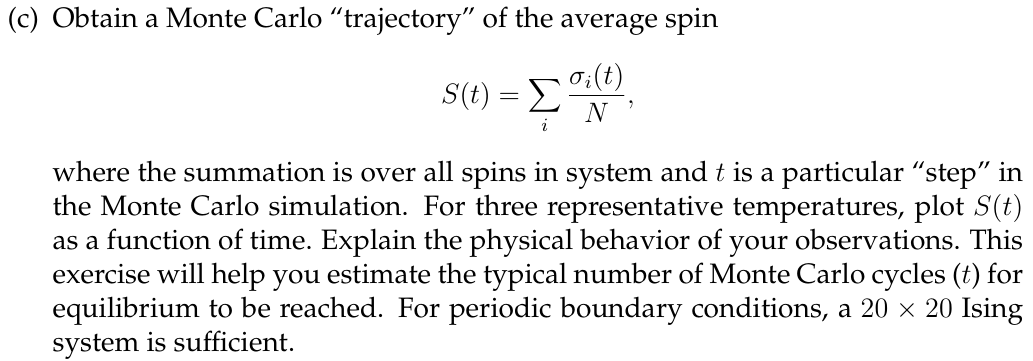


--- Ising Model Simulation ---

Simulating spin trajectory...
--- Starting trajectory simulation for L=20, T=2.27 ---
Equilibrating for 1000 steps at T=2.27...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 42295.79it/s]


Running simulation for 1000 steps at T=2.27...


Simulation: 100%|██████████| 1000/1000 [00:00<00:00, 39894.08it/s]

--- Finished trajectory simulation ---


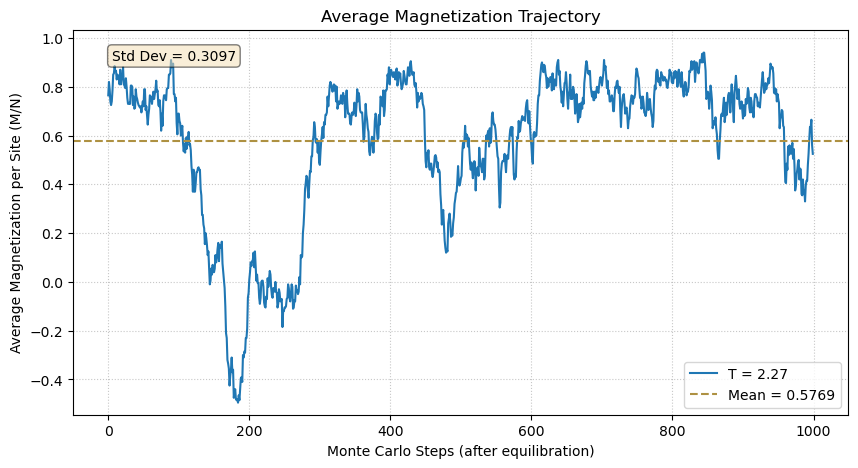

In [12]:
# --- Main execution block (Example Usage) ---
print("--- Ising Model Simulation ---")
# Simulate and plot average spin trajectory near Tc
print("\nSimulating spin trajectory...")
L_traj = 20
T_traj = 2.27 # Near Tc
traj_steps = 2000
traj_eq_steps = 1000
avg_spin_traj = get_average_spin_trajectory(L=L_traj, T=T_traj, num_steps=traj_steps, equilibration_steps=traj_eq_steps)
plot_average_spin_trajectory(avg_spin_traj, T_traj)

--- Starting trajectory simulation for L=20, T=1.50 ---
Equilibrating for 1000 steps at T=1.50...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 22708.37it/s]


Running simulation for 1000 steps at T=1.50...


Simulation: 100%|██████████| 1000/1000 [00:00<00:00, 24185.81it/s]

--- Finished trajectory simulation ---


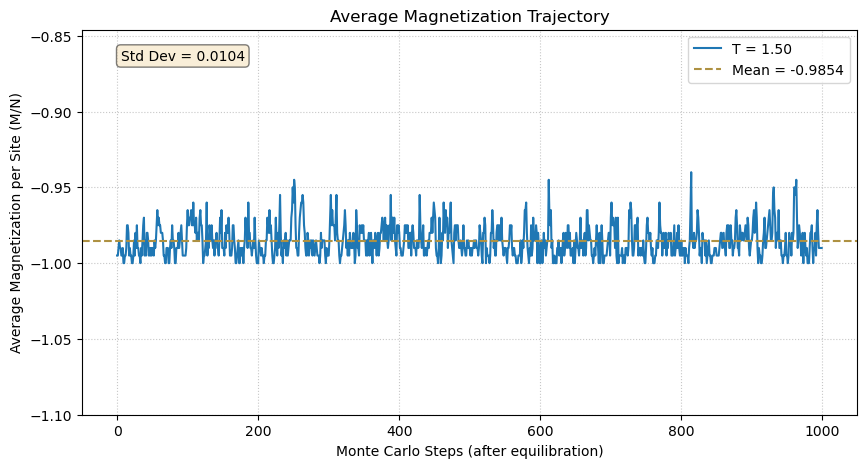

In [6]:
T_traj = 1.5 # Ferromagnetic phase
avg_spin_traj = get_average_spin_trajectory(L=L_traj, T=T_traj, num_steps=traj_steps, equilibration_steps=traj_eq_steps)
plot_average_spin_trajectory(avg_spin_traj, T_traj)


--- Starting trajectory simulation for L=20, T=3.00 ---
Equilibrating for 1000 steps at T=3.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 2867.01it/s]


Running simulation for 1000 steps at T=3.00...


Simulation: 100%|██████████| 1000/1000 [00:00<00:00, 3587.82it/s]


--- Finished trajectory simulation ---


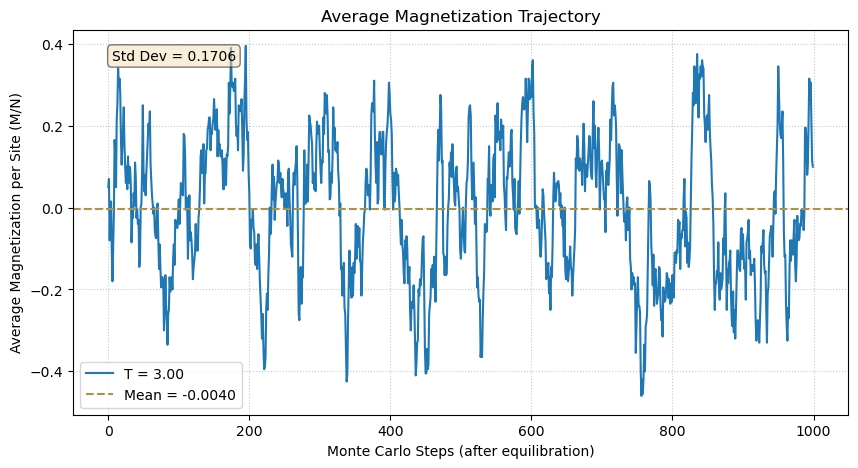

In [17]:
T_traj = 3.0 # Paramagnetic phase
avg_spin_traj = get_average_spin_trajectory(L=L_traj, T=T_traj, num_steps=traj_steps, equilibration_steps=traj_eq_steps)
plot_average_spin_trajectory(avg_spin_traj, T_traj)

# Question D
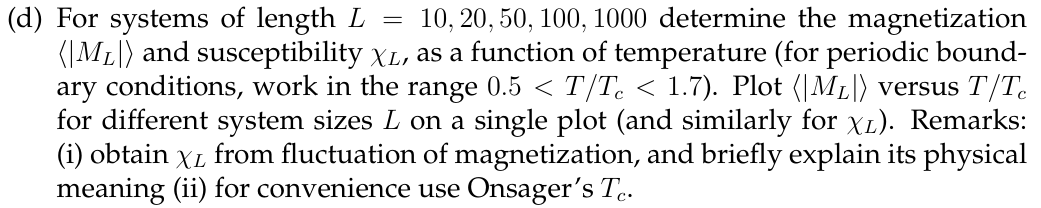

# Answer to Question D

In [ ]:

def calculate_magnetization_and_susceptibility(L, T, num_steps=3000, equilibration_steps=1000):
    """
    Runs simulation and calculates the average absolute magnetization per site
    and magnetic susceptibility per site.

    Args:
        L (int): Lattice size.
        T (float): Temperature.
        num_steps (int): Total simulation steps.
        equilibration_steps (int): Steps to discard for equilibration.

    Returns:
        tuple: (avg_abs_mag_per_site, susceptibility_per_site)
               - avg_abs_mag_per_site: <|M|>/N
               - susceptibility_per_site: χ/N = (β / N) * (<M^2> - <M>^2)
    """
    if T <= 0: beta = np.inf
    else: beta = 1.0 / T

    model = Ising2D(L=L, initial_state='random') # Start fresh for each T
    N = model.N
    _, magnetizations_norm = model.run_simulation(T, num_steps, equilibration_steps)

    # Convert normalized magnetizations (M/N) back to total M for calculations
    magnetizations_total = [m * N for m in magnetizations_norm]

    # Use measurements *after* equilibration
    M_vals = np.array(magnetizations_total) # Total M values
    M_abs_vals = np.abs(M_vals)             # Absolute |M| values

    # Average absolute magnetization per site: <|M|> / N
    avg_abs_mag_per_site = np.mean(M_abs_vals) / N

    # Susceptibility per site: χ/N = (β / N) * (<M^2> - <M>^2)
    # Note: Using <M>^2 is standard. If M fluctuates around 0 (high T), <M> ≈ 0.
    # If M fluctuates around non-zero M_0 (low T), <M> ≈ M_0.
    M_sq_avg = np.mean(M_vals**2)
    M_avg_sq = np.mean(M_vals)**2
    susceptibility_per_site = (beta / N) * (M_sq_avg - M_avg_sq) if T > 0 else 0.0

    return avg_abs_mag_per_site, susceptibility_per_site

def plot_magnetization_and_susceptibility_vs_T(L_values, T_range):
    """
    Calculates and plots average magnetization and susceptibility vs. temperature
    for different lattice sizes L.

    Args:
        L_values (list or array): List of lattice sizes L to simulate.
        T_range (list or array): Range of temperatures T to simulate.
    """
    results = {} # Store results as {L: {'T': [], 'M': [], 'Chi': []}}

    num_steps=5000          # Adjust as needed for accuracy
    equilibration_steps=1000 # Adjust as needed

    for L in L_values:
        print(f"\n--- Simulating for L = {L} ---")
        results[L] = {'T': [], 'M': [], 'Chi': []}
        # Use tqdm for progress bar over temperatures
        for T in tqdm(T_range, desc=f"L={L}"):
            avg_M_abs_norm, susc_norm = calculate_magnetization_and_susceptibility(
                L, T, num_steps=num_steps, equilibration_steps=equilibration_steps
            )
            results[L]['T'].append(T)
            results[L]['M'].append(avg_M_abs_norm)
            results[L]['Chi'].append(susc_norm)

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

    # Plot Magnetization
    ax1 = axes[0]
    for L in L_values:
        ax1.plot(results[L]['T'], results[L]['M'], 'o-', markersize=4, label=f'L={L}')
    ax1.set_ylabel('Average Absolute Magnetization per Site $\langle|M|\\rangle/N$')
    ax1.set_title('Ising Model: Magnetization vs. Temperature')
    ax1.legend()
    ax1.grid(True, linestyle=':', alpha=0.7)

    # Plot Susceptibility
    ax2 = axes[1]
    Tc_exact = 2 / np.log(1 + np.sqrt(2)) # Exact Tc for infinite 2D Ising model
    for L in L_values:
        ax2.plot(results[L]['T'], results[L]['Chi'], 'o-', markersize=4, label=f'L={L}')
    ax2.axvline(Tc_exact, color='grey', linestyle='--', label=f'$T_c$ (exact) ≈ {Tc_exact:.4f}')
    ax2.set_xlabel('Temperature (T)')
    ax2.set_ylabel('Susceptibility per Site $\chi/N$')
    ax2.set_title('Ising Model: Susceptibility vs. Temperature')
    ax2.legend()
    ax2.grid(True, linestyle=':', alpha=0.7)


    plt.tight_layout()
    plt.show()

    # Return results dictionary for further analysis if needed
    return results


def estimate_critical_temperature_and_gamma(L_values, T_range, num_steps=5000, equilibration_steps=1000):
    """
    Estimates the critical temperature Tc by finding the peak of the susceptibility
    for the largest lattice size. Also discusses how gamma could be estimated.

    Args:
        L_values (list or array): List of lattice sizes L simulated.
        T_range (list or array): Range of temperatures T simulated.
        num_steps (int): Simulation steps used (passed to calculation).
        equilibration_steps (int): Equilibration steps used (passed to calculation).

    Returns:
        float: Estimated critical temperature Tc based on susceptibility peak of largest L.
    """
    # Re-run or use pre-computed results if available
    # For simplicity, let's assume we need to compute it here
    results = {}
    print("\n--- Calculating Susceptibility for Tc Estimation ---")
    for L in L_values:
        results[L] = {'T': [], 'Chi': []}
        for T in tqdm(T_range, desc=f"Estimating Tc (L={L})"):
             _, susc_norm = calculate_magnetization_and_susceptibility(
                L, T, num_steps=num_steps, equilibration_steps=equilibration_steps
            )
             results[L]['T'].append(T)
             results[L]['Chi'].append(susc_norm)


    # Find Tc estimate from the peak of Chi for the largest L
    largest_L = max(L_values)
    chi_values = np.array(results[largest_L]['Chi'])
    temp_values = np.array(results[largest_L]['T'])

    if len(chi_values) > 0:
        peak_index = np.argmax(chi_values)
        Tc_estimated = temp_values[peak_index]
        peak_chi = chi_values[peak_index]
        print(f"\nEstimated Critical Temperature (Tc) from peak of χ for L={largest_L}: {Tc_estimated:.4f}")
        print(f"Peak Susceptibility (χ/N) at L={largest_L}: {peak_chi:.4f}")
        print("\nTo estimate gamma (γ):")
        print("1. Find the peak susceptibility (χ_max) for each lattice size L.")
        print("2. Plot log(χ_max) against log(L).")
        print("3. The slope of this plot (for large L) approximates γ (since ν=1 in 2D Ising).")
        # Example (requires chi_max values for multiple L):
        # log_L = np.log([L for L in L_values])
        # log_chi_max = np.log([np.max(results[L]['Chi']) for L in L_values])
        # plt.plot(log_L, log_chi_max, 'o-')
        # plt.xlabel('log(L)')
        # plt.ylabel('log(χ_max/N)')
        # plt.title('Finite-Size Scaling of Susceptibility Peak')
        # plt.show()
        # fit = np.polyfit(log_L, log_chi_max, 1) # Slope is estimate for gamma
        # print(f"Estimated gamma from slope: {fit[0]:.4f} (Exact 2D Ising gamma = 7/4 = 1.75)")

        return Tc_estimated
    else:
        print("No susceptibility data available to estimate Tc.")
        return None



<>:76: SyntaxWarning: invalid escape sequence '\l'
<>:88: SyntaxWarning: invalid escape sequence '\c'
<>:76: SyntaxWarning: invalid escape sequence '\l'
<>:88: SyntaxWarning: invalid escape sequence '\c'
C:\Users\bpiguave\AppData\Local\Temp\ipykernel_17796\1357015980.py:76: SyntaxWarning: invalid escape sequence '\l'
  ax1.set_ylabel('Average Absolute Magnetization per Site $\langle|M|\\rangle/N$')
C:\Users\bpiguave\AppData\Local\Temp\ipykernel_17796\1357015980.py:88: SyntaxWarning: invalid escape sequence '\c'
  ax2.set_ylabel('Susceptibility per Site $\chi/N$')



Calculating M and Chi vs T...

--- Simulating for L = 8 ---


L=8:   0%|          | 0/40 [00:00<?, ?it/s]

Equilibrating for 1000 steps at T=1.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 117415.15it/s]


Running simulation for 4000 steps at T=1.00...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 73211.48it/s]


Equilibrating for 1000 steps at T=1.10...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 153283.78it/s]


Running simulation for 4000 steps at T=1.10...


L=8:   5%|▌         | 2/40 [00:00<00:02, 13.00it/s]

Equilibrating for 1000 steps at T=1.20...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 119291.92it/s]


Running simulation for 4000 steps at T=1.20...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 105445.46it/s]


Equilibrating for 1000 steps at T=1.30...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 123083.14it/s]


Running simulation for 4000 steps at T=1.30...


L=8:  10%|█         | 4/40 [00:00<00:02, 16.16it/s]

Equilibrating for 1000 steps at T=1.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 195757.68it/s]


Running simulation for 4000 steps at T=1.40...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 172884.35it/s]


Equilibrating for 1000 steps at T=1.50...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 105112.50it/s]


Running simulation for 4000 steps at T=1.50...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 139693.72it/s]


Equilibrating for 1000 steps at T=1.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 171581.26it/s]


Running simulation for 4000 steps at T=1.60...


L=8:  18%|█▊        | 7/40 [00:00<00:01, 19.82it/s]

Equilibrating for 1000 steps at T=1.70...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 177199.16it/s]


Running simulation for 4000 steps at T=1.70...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 146560.46it/s]


Equilibrating for 1000 steps at T=1.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 214334.10it/s]


Running simulation for 4000 steps at T=1.80...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 172409.99it/s]


Equilibrating for 1000 steps at T=1.90...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 201668.62it/s]


Running simulation for 4000 steps at T=1.90...


L=8:  25%|██▌       | 10/40 [00:00<00:01, 21.81it/s]

Equilibrating for 1000 steps at T=2.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 110655.97it/s]


Running simulation for 4000 steps at T=2.00...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 155279.89it/s]


Equilibrating for 1000 steps at T=2.05...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 193947.29it/s]


Running simulation for 4000 steps at T=2.05...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 138724.61it/s]


Equilibrating for 1000 steps at T=2.07...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 133674.47it/s]


Running simulation for 4000 steps at T=2.07...


L=8:  32%|███▎      | 13/40 [00:00<00:01, 21.40it/s]

Equilibrating for 1000 steps at T=2.10...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 115772.01it/s]


Running simulation for 4000 steps at T=2.10...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 124752.51it/s]


Equilibrating for 1000 steps at T=2.12...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 90831.02it/s]


Running simulation for 4000 steps at T=2.12...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 109322.04it/s]


Equilibrating for 1000 steps at T=2.15...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 73172.21it/s]


Running simulation for 4000 steps at T=2.15...


L=8:  40%|████      | 16/40 [00:00<00:01, 17.63it/s]

Equilibrating for 1000 steps at T=2.17...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 51788.56it/s]


Running simulation for 4000 steps at T=2.17...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 57478.46it/s]


Equilibrating for 1000 steps at T=2.20...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 64102.70it/s]


Running simulation for 4000 steps at T=2.20...


L=8:  45%|████▌     | 18/40 [00:01<00:01, 14.76it/s]

Equilibrating for 1000 steps at T=2.22...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 79362.42it/s]


Running simulation for 4000 steps at T=2.22...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 53297.21it/s]


Equilibrating for 1000 steps at T=2.25...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 53300.26it/s]


Running simulation for 4000 steps at T=2.25...


L=8:  50%|█████     | 20/40 [00:01<00:01, 12.88it/s]

Equilibrating for 1000 steps at T=2.27...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 54616.18it/s]


Running simulation for 4000 steps at T=2.27...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 65464.65it/s]


Equilibrating for 1000 steps at T=2.30...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 60667.44it/s]


Running simulation for 4000 steps at T=2.30...


L=8:  55%|█████▌    | 22/40 [00:01<00:01, 12.05it/s]

Equilibrating for 1000 steps at T=2.32...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 93562.29it/s]


Running simulation for 4000 steps at T=2.32...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 82171.97it/s]


Equilibrating for 1000 steps at T=2.35...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 74739.46it/s]


Running simulation for 4000 steps at T=2.35...


L=8:  60%|██████    | 24/40 [00:01<00:01, 12.06it/s]

Equilibrating for 1000 steps at T=2.38...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 67256.29it/s]


Running simulation for 4000 steps at T=2.38...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 77733.12it/s]


Equilibrating for 1000 steps at T=2.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 66039.55it/s]


Running simulation for 4000 steps at T=2.40...


L=8:  65%|██████▌   | 26/40 [00:01<00:01, 11.89it/s]

Equilibrating for 1000 steps at T=2.42...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 92355.04it/s]


Running simulation for 4000 steps at T=2.42...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 76170.40it/s]


Equilibrating for 1000 steps at T=2.45...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 62722.32it/s]


Running simulation for 4000 steps at T=2.45...


L=8:  70%|███████   | 28/40 [00:01<00:01, 11.85it/s]

Equilibrating for 1000 steps at T=2.47...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 80524.97it/s]


Running simulation for 4000 steps at T=2.47...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 75269.59it/s]


Equilibrating for 1000 steps at T=2.50...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 86988.07it/s]


Running simulation for 4000 steps at T=2.50...


L=8:  75%|███████▌  | 30/40 [00:02<00:00, 11.78it/s]

Equilibrating for 1000 steps at T=2.52...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 73065.13it/s]


Running simulation for 4000 steps at T=2.52...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 93550.29it/s]


Equilibrating for 1000 steps at T=2.55...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 90809.39it/s]


Running simulation for 4000 steps at T=2.55...


L=8:  80%|████████  | 32/40 [00:02<00:00, 12.27it/s]

Equilibrating for 1000 steps at T=2.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 34673.13it/s]


Running simulation for 4000 steps at T=2.60...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 46800.20it/s]


Equilibrating for 1000 steps at T=2.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 56447.13it/s]


Running simulation for 4000 steps at T=2.80...


L=8:  85%|████████▌ | 34/40 [00:02<00:00, 10.59it/s]

Equilibrating for 1000 steps at T=3.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 53147.62it/s]


Running simulation for 4000 steps at T=3.00...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 71368.42it/s]


Equilibrating for 1000 steps at T=3.20...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 101907.38it/s]


Running simulation for 4000 steps at T=3.20...


L=8:  90%|█████████ | 36/40 [00:02<00:00, 11.02it/s]

Equilibrating for 1000 steps at T=3.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 75643.92it/s]


Running simulation for 4000 steps at T=3.40...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 87821.81it/s]


Equilibrating for 1000 steps at T=3.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 101138.24it/s]


Running simulation for 4000 steps at T=3.60...


L=8:  95%|█████████▌| 38/40 [00:02<00:00, 11.69it/s]

Equilibrating for 1000 steps at T=3.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 107510.42it/s]


Running simulation for 4000 steps at T=3.80...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 79473.70it/s]


Equilibrating for 1000 steps at T=4.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 76799.06it/s]


Running simulation for 4000 steps at T=4.00...


L=8: 100%|██████████| 40/40 [00:03<00:00, 13.27it/s]



--- Simulating for L = 16 ---


L=16:   0%|          | 0/40 [00:00<?, ?it/s]

Equilibrating for 1000 steps at T=1.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 37917.35it/s]


Running simulation for 4000 steps at T=1.00...


L=16:   2%|▎         | 1/40 [00:00<00:05,  6.58it/s]

Equilibrating for 1000 steps at T=1.10...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 38108.90it/s]


Running simulation for 4000 steps at T=1.10...


L=16:   5%|▌         | 2/40 [00:00<00:06,  6.07it/s]

Equilibrating for 1000 steps at T=1.20...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 37183.55it/s]


Running simulation for 4000 steps at T=1.20...


L=16:   8%|▊         | 3/40 [00:00<00:05,  6.19it/s]

Equilibrating for 1000 steps at T=1.30...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 34804.61it/s]


Running simulation for 4000 steps at T=1.30...


L=16:  10%|█         | 4/40 [00:00<00:05,  6.03it/s]

Equilibrating for 1000 steps at T=1.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 33175.70it/s]


Running simulation for 4000 steps at T=1.40...


L=16:  12%|█▎        | 5/40 [00:00<00:05,  5.97it/s]

Equilibrating for 1000 steps at T=1.50...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 34353.92it/s]


Running simulation for 4000 steps at T=1.50...


L=16:  15%|█▌        | 6/40 [00:00<00:05,  5.90it/s]

Equilibrating for 1000 steps at T=1.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 34871.75it/s]


Running simulation for 4000 steps at T=1.60...


L=16:  18%|█▊        | 7/40 [00:01<00:07,  4.71it/s]

Equilibrating for 1000 steps at T=1.70...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 34906.28it/s]


Running simulation for 4000 steps at T=1.70...


L=16:  20%|██        | 8/40 [00:01<00:06,  5.02it/s]

Equilibrating for 1000 steps at T=1.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 37695.85it/s]


Running simulation for 4000 steps at T=1.80...


L=16:  22%|██▎       | 9/40 [00:01<00:05,  5.41it/s]

Equilibrating for 1000 steps at T=1.90...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 37664.71it/s]


Running simulation for 4000 steps at T=1.90...


L=16:  25%|██▌       | 10/40 [00:01<00:05,  5.52it/s]

Equilibrating for 1000 steps at T=2.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 40319.38it/s]


Running simulation for 4000 steps at T=2.00...


L=16:  28%|██▊       | 11/40 [00:01<00:05,  5.80it/s]

Equilibrating for 1000 steps at T=2.05...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 34419.89it/s]


Running simulation for 4000 steps at T=2.05...


L=16:  30%|███       | 12/40 [00:02<00:04,  5.78it/s]

Equilibrating for 1000 steps at T=2.07...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 31778.88it/s]


Running simulation for 4000 steps at T=2.07...


L=16:  32%|███▎      | 13/40 [00:02<00:04,  5.76it/s]

Equilibrating for 1000 steps at T=2.10...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 25020.60it/s]


Running simulation for 4000 steps at T=2.10...


L=16:  35%|███▌      | 14/40 [00:02<00:04,  5.49it/s]

Equilibrating for 1000 steps at T=2.12...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 32501.64it/s]


Running simulation for 4000 steps at T=2.12...


L=16:  38%|███▊      | 15/40 [00:02<00:04,  5.71it/s]

Equilibrating for 1000 steps at T=2.15...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 38985.59it/s]


Running simulation for 4000 steps at T=2.15...


L=16:  40%|████      | 16/40 [00:02<00:04,  5.98it/s]

Equilibrating for 1000 steps at T=2.17...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 39010.25it/s]


Running simulation for 4000 steps at T=2.17...


L=16:  42%|████▎     | 17/40 [00:02<00:03,  5.97it/s]

Equilibrating for 1000 steps at T=2.20...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 31865.07it/s]


Running simulation for 4000 steps at T=2.20...


L=16:  45%|████▌     | 18/40 [00:03<00:03,  5.78it/s]

Equilibrating for 1000 steps at T=2.22...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 39136.56it/s]


Running simulation for 4000 steps at T=2.22...


L=16:  48%|████▊     | 19/40 [00:03<00:04,  5.02it/s]

Equilibrating for 1000 steps at T=2.25...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 31731.76it/s]


Running simulation for 4000 steps at T=2.25...


L=16:  50%|█████     | 20/40 [00:03<00:04,  4.98it/s]

Equilibrating for 1000 steps at T=2.27...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 25323.34it/s]


Running simulation for 4000 steps at T=2.27...


L=16:  52%|█████▎    | 21/40 [00:03<00:03,  5.00it/s]

Equilibrating for 1000 steps at T=2.30...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 32542.49it/s]

Running simulation for 4000 steps at T=2.30...



L=16:  55%|█████▌    | 22/40 [00:04<00:03,  5.20it/s]

Equilibrating for 1000 steps at T=2.32...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 31802.50it/s]


Running simulation for 4000 steps at T=2.32...


L=16:  57%|█████▊    | 23/40 [00:04<00:03,  5.34it/s]

Equilibrating for 1000 steps at T=2.35...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 35283.31it/s]

Running simulation for 4000 steps at T=2.35...



L=16:  60%|██████    | 24/40 [00:04<00:02,  5.51it/s]

Equilibrating for 1000 steps at T=2.38...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 35806.21it/s]


Running simulation for 4000 steps at T=2.38...


L=16:  62%|██████▎   | 25/40 [00:04<00:02,  5.60it/s]

Equilibrating for 1000 steps at T=2.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 35047.16it/s]


Running simulation for 4000 steps at T=2.40...


L=16:  65%|██████▌   | 26/40 [00:04<00:02,  5.76it/s]

Equilibrating for 1000 steps at T=2.42...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 27323.21it/s]


Running simulation for 4000 steps at T=2.42...


L=16:  68%|██████▊   | 27/40 [00:04<00:02,  5.74it/s]

Equilibrating for 1000 steps at T=2.45...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 29119.43it/s]


Running simulation for 4000 steps at T=2.45...


L=16:  70%|███████   | 28/40 [00:05<00:02,  5.80it/s]

Equilibrating for 1000 steps at T=2.47...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 37241.32it/s]


Running simulation for 4000 steps at T=2.47...


L=16:  72%|███████▎  | 29/40 [00:05<00:01,  5.87it/s]

Equilibrating for 1000 steps at T=2.50...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 36947.06it/s]


Running simulation for 4000 steps at T=2.50...


L=16:  75%|███████▌  | 30/40 [00:05<00:02,  5.00it/s]

Equilibrating for 1000 steps at T=2.52...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 31820.11it/s]


Running simulation for 4000 steps at T=2.52...


L=16:  78%|███████▊  | 31/40 [00:05<00:01,  5.14it/s]

Equilibrating for 1000 steps at T=2.55...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 36068.24it/s]


Running simulation for 4000 steps at T=2.55...


L=16:  80%|████████  | 32/40 [00:05<00:01,  5.34it/s]

Equilibrating for 1000 steps at T=2.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 36187.74it/s]


Running simulation for 4000 steps at T=2.60...


L=16:  82%|████████▎ | 33/40 [00:05<00:01,  5.59it/s]

Equilibrating for 1000 steps at T=2.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 35861.32it/s]


Running simulation for 4000 steps at T=2.80...


L=16:  85%|████████▌ | 34/40 [00:06<00:01,  5.76it/s]

Equilibrating for 1000 steps at T=3.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 35744.88it/s]


Running simulation for 4000 steps at T=3.00...


L=16:  88%|████████▊ | 35/40 [00:06<00:00,  5.96it/s]

Equilibrating for 1000 steps at T=3.20...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 38781.57it/s]


Running simulation for 4000 steps at T=3.20...


L=16:  90%|█████████ | 36/40 [00:06<00:00,  6.12it/s]

Equilibrating for 1000 steps at T=3.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 35086.45it/s]


Running simulation for 4000 steps at T=3.40...


L=16:  92%|█████████▎| 37/40 [00:06<00:00,  6.21it/s]

Equilibrating for 1000 steps at T=3.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 33807.58it/s]

Running simulation for 4000 steps at T=3.60...



L=16:  95%|█████████▌| 38/40 [00:06<00:00,  6.12it/s]

Equilibrating for 1000 steps at T=3.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 28827.23it/s]


Running simulation for 4000 steps at T=3.80...


L=16:  98%|█████████▊| 39/40 [00:07<00:00,  5.01it/s]

Equilibrating for 1000 steps at T=4.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 30957.24it/s]


Running simulation for 4000 steps at T=4.00...


L=16: 100%|██████████| 40/40 [00:07<00:00,  5.52it/s]



--- Simulating for L = 32 ---


L=32:   0%|          | 0/40 [00:00<?, ?it/s]

Equilibrating for 1000 steps at T=1.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 10596.55it/s]


Running simulation for 4000 steps at T=1.00...


L=32:   2%|▎         | 1/40 [00:00<00:18,  2.06it/s]

Equilibrating for 1000 steps at T=1.10...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 12461.57it/s]


Running simulation for 4000 steps at T=1.10...


L=32:   5%|▌         | 2/40 [00:00<00:17,  2.13it/s]

Equilibrating for 1000 steps at T=1.20...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 12960.90it/s]


Running simulation for 4000 steps at T=1.20...


L=32:   8%|▊         | 3/40 [00:01<00:16,  2.20it/s]

Equilibrating for 1000 steps at T=1.30...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 11721.66it/s]


Running simulation for 4000 steps at T=1.30...


L=32:  10%|█         | 4/40 [00:01<00:16,  2.24it/s]

Equilibrating for 1000 steps at T=1.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 11760.45it/s]


Running simulation for 4000 steps at T=1.40...


L=32:  12%|█▎        | 5/40 [00:02<00:15,  2.21it/s]

Equilibrating for 1000 steps at T=1.50...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 12154.27it/s]


Running simulation for 4000 steps at T=1.50...


L=32:  15%|█▌        | 6/40 [00:02<00:16,  2.09it/s]

Equilibrating for 1000 steps at T=1.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 9446.65it/s]


Running simulation for 4000 steps at T=1.60...


L=32:  18%|█▊        | 7/40 [00:03<00:17,  1.91it/s]

Equilibrating for 1000 steps at T=1.70...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 9203.40it/s]


Running simulation for 4000 steps at T=1.70...


L=32:  20%|██        | 8/40 [00:04<00:17,  1.84it/s]

Equilibrating for 1000 steps at T=1.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 11115.19it/s]


Running simulation for 4000 steps at T=1.80...


L=32:  22%|██▎       | 9/40 [00:04<00:16,  1.91it/s]

Equilibrating for 1000 steps at T=1.90...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 12175.30it/s]


Running simulation for 4000 steps at T=1.90...


L=32:  25%|██▌       | 10/40 [00:04<00:14,  2.01it/s]

Equilibrating for 1000 steps at T=2.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 12356.69it/s]


Running simulation for 4000 steps at T=2.00...


L=32:  28%|██▊       | 11/40 [00:05<00:13,  2.10it/s]

Equilibrating for 1000 steps at T=2.05...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 13043.17it/s]


Running simulation for 4000 steps at T=2.05...


L=32:  30%|███       | 12/40 [00:05<00:12,  2.18it/s]

Equilibrating for 1000 steps at T=2.07...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 11795.04it/s]


Running simulation for 4000 steps at T=2.07...


L=32:  32%|███▎      | 13/40 [00:06<00:12,  2.23it/s]

Equilibrating for 1000 steps at T=2.10...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 12107.64it/s]


Running simulation for 4000 steps at T=2.10...


L=32:  35%|███▌      | 14/40 [00:06<00:11,  2.18it/s]

Equilibrating for 1000 steps at T=2.12...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 10631.19it/s]


Running simulation for 4000 steps at T=2.12...


L=32:  38%|███▊      | 15/40 [00:07<00:11,  2.18it/s]

Equilibrating for 1000 steps at T=2.15...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 12653.72it/s]


Running simulation for 4000 steps at T=2.15...


L=32:  40%|████      | 16/40 [00:07<00:10,  2.23it/s]

Equilibrating for 1000 steps at T=2.17...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 12645.67it/s]


Running simulation for 4000 steps at T=2.17...


L=32:  42%|████▎     | 17/40 [00:08<00:10,  2.25it/s]

Equilibrating for 1000 steps at T=2.20...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 13003.01it/s]


Running simulation for 4000 steps at T=2.20...


L=32:  45%|████▌     | 18/40 [00:08<00:09,  2.26it/s]

Equilibrating for 1000 steps at T=2.22...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 12031.06it/s]


Running simulation for 4000 steps at T=2.22...


L=32:  48%|████▊     | 19/40 [00:08<00:09,  2.24it/s]

Equilibrating for 1000 steps at T=2.25...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 11776.69it/s]


Running simulation for 4000 steps at T=2.25...


L=32:  50%|█████     | 20/40 [00:09<00:09,  2.22it/s]

Equilibrating for 1000 steps at T=2.27...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 10981.41it/s]


Running simulation for 4000 steps at T=2.27...


L=32:  52%|█████▎    | 21/40 [00:09<00:09,  2.10it/s]

Equilibrating for 1000 steps at T=2.30...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 10808.67it/s]


Running simulation for 4000 steps at T=2.30...


L=32:  55%|█████▌    | 22/40 [00:10<00:08,  2.07it/s]

Equilibrating for 1000 steps at T=2.32...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 10234.00it/s]


Running simulation for 4000 steps at T=2.32...


L=32:  57%|█████▊    | 23/40 [00:10<00:08,  1.94it/s]

Equilibrating for 1000 steps at T=2.35...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 5519.69it/s]


Running simulation for 4000 steps at T=2.35...


L=32:  60%|██████    | 24/40 [00:11<00:09,  1.73it/s]

Equilibrating for 1000 steps at T=2.38...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 9246.97it/s]


Running simulation for 4000 steps at T=2.38...


L=32:  62%|██████▎   | 25/40 [00:12<00:08,  1.71it/s]

Equilibrating for 1000 steps at T=2.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 10819.71it/s]


Running simulation for 4000 steps at T=2.40...


L=32:  65%|██████▌   | 26/40 [00:12<00:07,  1.79it/s]

Equilibrating for 1000 steps at T=2.42...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 11071.85it/s]


Running simulation for 4000 steps at T=2.42...


L=32:  68%|██████▊   | 27/40 [00:13<00:06,  1.88it/s]

Equilibrating for 1000 steps at T=2.45...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 12324.15it/s]


Running simulation for 4000 steps at T=2.45...


L=32:  70%|███████   | 28/40 [00:13<00:06,  1.99it/s]

Equilibrating for 1000 steps at T=2.47...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 12386.57it/s]


Running simulation for 4000 steps at T=2.47...


L=32:  72%|███████▎  | 29/40 [00:14<00:05,  2.09it/s]

Equilibrating for 1000 steps at T=2.50...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 12597.97it/s]


Running simulation for 4000 steps at T=2.50...


L=32:  75%|███████▌  | 30/40 [00:14<00:04,  2.17it/s]

Equilibrating for 1000 steps at T=2.52...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 12674.37it/s]


Running simulation for 4000 steps at T=2.52...


L=32:  78%|███████▊  | 31/40 [00:14<00:04,  2.21it/s]

Equilibrating for 1000 steps at T=2.55...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 12149.62it/s]


Running simulation for 4000 steps at T=2.55...


L=32:  80%|████████  | 32/40 [00:15<00:03,  2.02it/s]

Equilibrating for 1000 steps at T=2.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 10957.74it/s]


Running simulation for 4000 steps at T=2.60...


L=32:  82%|████████▎ | 33/40 [00:16<00:03,  1.88it/s]

Equilibrating for 1000 steps at T=2.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 6897.24it/s]


Running simulation for 4000 steps at T=2.80...


L=32:  85%|████████▌ | 34/40 [00:16<00:03,  1.73it/s]

Equilibrating for 1000 steps at T=3.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 7715.82it/s]


Running simulation for 4000 steps at T=3.00...


L=32:  88%|████████▊ | 35/40 [00:17<00:02,  1.71it/s]

Equilibrating for 1000 steps at T=3.20...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 9668.44it/s]


Running simulation for 4000 steps at T=3.20...


L=32:  90%|█████████ | 36/40 [00:18<00:02,  1.76it/s]

Equilibrating for 1000 steps at T=3.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 10873.45it/s]


Running simulation for 4000 steps at T=3.40...


L=32:  92%|█████████▎| 37/40 [00:18<00:01,  1.73it/s]

Equilibrating for 1000 steps at T=3.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 8255.19it/s]


Running simulation for 4000 steps at T=3.60...


L=32:  95%|█████████▌| 38/40 [00:19<00:01,  1.60it/s]

Equilibrating for 1000 steps at T=3.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 7908.44it/s]


Running simulation for 4000 steps at T=3.80...


L=32:  98%|█████████▊| 39/40 [00:19<00:00,  1.59it/s]

Equilibrating for 1000 steps at T=4.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 8360.07it/s]


Running simulation for 4000 steps at T=4.00...


L=32: 100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


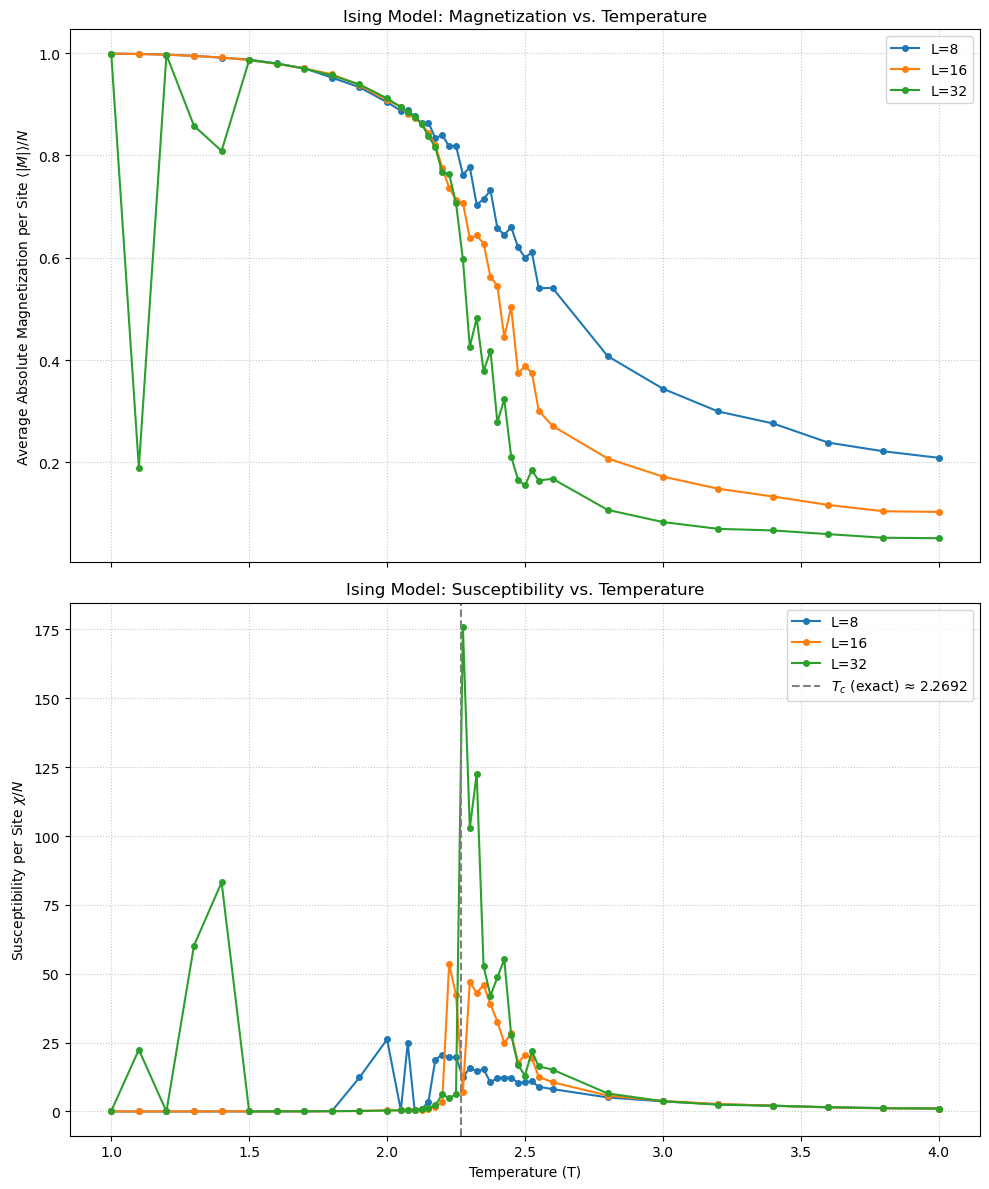

In [ ]:
# 3. Calculate and plot Magnetization and Susceptibility vs. T
print("\nCalculating M and Chi vs T...")
L_values_analysis = [10, 20, 50 ,100 , 1000] # Use larger L for better results near Tc
# T_range_analysis = np.linspace(1.5, 3.5, 41) # Fine grid around Tc_exact ≈ 2.269
T_range_analysis = np.concatenate([
    np.linspace(0,5, 2.0, 11), # Low T region
])

results_data = plot_magnetization_and_susceptibility_vs_T(L_values_analysis, T_range_analysis)


# Question D

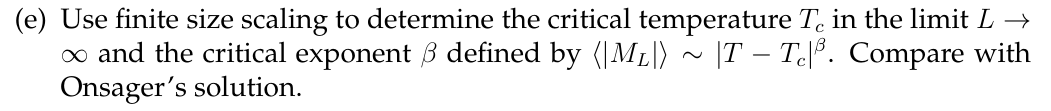

In [9]:
# 4. Estimate Critical Temperature
print("\nEstimating Critical Temperature...")
Tc_est = estimate_critical_temperature_and_gamma(
    L_values = L_values_analysis,
    T_range = T_range_analysis, # Use the same T range for consistency
    num_steps = 5000, # Match steps used in plot function or adjust
    equilibration_steps = 1000
)
if Tc_est is not None:
    Tc_exact = 2 / np.log(1 + np.sqrt(2))
    print(f"Comparison: Exact Tc (infinite lattice) ≈ {Tc_exact:.4f}")


Estimating Critical Temperature...

--- Calculating Susceptibility for Tc Estimation ---


Estimating Tc (L=8):   0%|          | 0/40 [00:00<?, ?it/s]

Equilibrating for 1000 steps at T=1.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 65178.54it/s]


Running simulation for 4000 steps at T=1.00...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 80043.97it/s]


Equilibrating for 1000 steps at T=1.10...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 94769.40it/s]


Running simulation for 4000 steps at T=1.10...


Estimating Tc (L=8):   5%|▌         | 2/40 [00:00<00:02, 13.13it/s]

Equilibrating for 1000 steps at T=1.20...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 75480.56it/s]


Running simulation for 4000 steps at T=1.20...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 84004.95it/s]


Equilibrating for 1000 steps at T=1.30...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 73306.49it/s]


Running simulation for 4000 steps at T=1.30...


Estimating Tc (L=8):  10%|█         | 4/40 [00:00<00:02, 12.55it/s]

Equilibrating for 1000 steps at T=1.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 115714.51it/s]


Running simulation for 4000 steps at T=1.40...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 85882.86it/s]


Equilibrating for 1000 steps at T=1.50...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 100195.98it/s]


Running simulation for 4000 steps at T=1.50...


Estimating Tc (L=8):  15%|█▌        | 6/40 [00:00<00:02, 13.00it/s]

Equilibrating for 1000 steps at T=1.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 80390.69it/s]


Running simulation for 4000 steps at T=1.60...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 109501.13it/s]


Equilibrating for 1000 steps at T=1.70...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 139987.45it/s]


Running simulation for 4000 steps at T=1.70...


Estimating Tc (L=8):  20%|██        | 8/40 [00:00<00:02, 14.04it/s]

Equilibrating for 1000 steps at T=1.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 282501.78it/s]


Running simulation for 4000 steps at T=1.80...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 77826.87it/s]


Equilibrating for 1000 steps at T=1.90...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 88453.84it/s]


Running simulation for 4000 steps at T=1.90...


Estimating Tc (L=8):  25%|██▌       | 10/40 [00:00<00:02, 13.44it/s]

Equilibrating for 1000 steps at T=2.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 61601.22it/s]


Running simulation for 4000 steps at T=2.00...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 90421.28it/s]


Equilibrating for 1000 steps at T=2.05...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 77412.82it/s]


Running simulation for 4000 steps at T=2.05...


Estimating Tc (L=8):  30%|███       | 12/40 [00:00<00:02, 12.57it/s]

Equilibrating for 1000 steps at T=2.07...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 66934.30it/s]


Running simulation for 4000 steps at T=2.07...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 84858.99it/s]


Equilibrating for 1000 steps at T=2.10...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 54933.78it/s]


Running simulation for 4000 steps at T=2.10...


Estimating Tc (L=8):  35%|███▌      | 14/40 [00:01<00:02, 12.27it/s]

Equilibrating for 1000 steps at T=2.12...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 87463.33it/s]


Running simulation for 4000 steps at T=2.12...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 61216.19it/s]


Equilibrating for 1000 steps at T=2.15...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 133444.82it/s]


Running simulation for 4000 steps at T=2.15...


Estimating Tc (L=8):  40%|████      | 16/40 [00:01<00:02, 11.88it/s]

Equilibrating for 1000 steps at T=2.17...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 67565.06it/s]


Running simulation for 4000 steps at T=2.17...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 95657.17it/s]


Equilibrating for 1000 steps at T=2.20...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 54603.38it/s]


Running simulation for 4000 steps at T=2.20...


Estimating Tc (L=8):  45%|████▌     | 18/40 [00:01<00:02, 10.48it/s]

Equilibrating for 1000 steps at T=2.22...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 72369.24it/s]


Running simulation for 4000 steps at T=2.22...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 54833.06it/s]


Equilibrating for 1000 steps at T=2.25...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 74355.23it/s]


Running simulation for 4000 steps at T=2.25...


Estimating Tc (L=8):  50%|█████     | 20/40 [00:01<00:01, 10.37it/s]

Equilibrating for 1000 steps at T=2.27...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 83288.07it/s]


Running simulation for 4000 steps at T=2.27...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 80605.83it/s]


Equilibrating for 1000 steps at T=2.30...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 86150.10it/s]


Running simulation for 4000 steps at T=2.30...


Estimating Tc (L=8):  55%|█████▌    | 22/40 [00:01<00:01, 11.08it/s]

Equilibrating for 1000 steps at T=2.32...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 100157.70it/s]


Running simulation for 4000 steps at T=2.32...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 99637.23it/s]


Equilibrating for 1000 steps at T=2.35...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 111571.41it/s]


Running simulation for 4000 steps at T=2.35...


Estimating Tc (L=8):  60%|██████    | 24/40 [00:02<00:01, 12.01it/s]

Equilibrating for 1000 steps at T=2.38...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 121945.17it/s]


Running simulation for 4000 steps at T=2.38...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 90474.92it/s]


Equilibrating for 1000 steps at T=2.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 70181.11it/s]


Running simulation for 4000 steps at T=2.40...


Estimating Tc (L=8):  65%|██████▌   | 26/40 [00:02<00:01, 12.65it/s]

Equilibrating for 1000 steps at T=2.42...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 99252.32it/s]


Running simulation for 4000 steps at T=2.42...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 99654.99it/s]


Equilibrating for 1000 steps at T=2.45...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 77089.84it/s]


Running simulation for 4000 steps at T=2.45...


Estimating Tc (L=8):  70%|███████   | 28/40 [00:02<00:00, 12.48it/s]

Equilibrating for 1000 steps at T=2.47...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 76339.19it/s]


Running simulation for 4000 steps at T=2.47...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 64005.62it/s]


Equilibrating for 1000 steps at T=2.50...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 60768.52it/s]


Running simulation for 4000 steps at T=2.50...


Estimating Tc (L=8):  75%|███████▌  | 30/40 [00:02<00:00, 11.88it/s]

Equilibrating for 1000 steps at T=2.52...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 96279.13it/s]


Running simulation for 4000 steps at T=2.52...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 68926.88it/s]


Equilibrating for 1000 steps at T=2.55...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 70344.72it/s]


Running simulation for 4000 steps at T=2.55...


Estimating Tc (L=8):  80%|████████  | 32/40 [00:02<00:00, 10.29it/s]

Equilibrating for 1000 steps at T=2.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 64679.00it/s]

Running simulation for 4000 steps at T=2.60...



Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 64841.74it/s]


Equilibrating for 1000 steps at T=2.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 45077.26it/s]


Running simulation for 4000 steps at T=2.80...


Estimating Tc (L=8):  85%|████████▌ | 34/40 [00:02<00:00, 10.15it/s]

Equilibrating for 1000 steps at T=3.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 65618.02it/s]


Running simulation for 4000 steps at T=3.00...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 95623.37it/s]

Equilibrating for 1000 steps at T=3.20...

Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 97662.33it/s]


Running simulation for 4000 steps at T=3.20...


Estimating Tc (L=8):  90%|█████████ | 36/40 [00:03<00:00, 10.94it/s]

Equilibrating for 1000 steps at T=3.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 98880.29it/s]


Running simulation for 4000 steps at T=3.40...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 94400.93it/s]


Equilibrating for 1000 steps at T=3.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 67841.55it/s]


Running simulation for 4000 steps at T=3.60...


Estimating Tc (L=8):  95%|█████████▌| 38/40 [00:03<00:00, 11.56it/s]

Equilibrating for 1000 steps at T=3.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 111057.38it/s]


Running simulation for 4000 steps at T=3.80...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 53676.79it/s]


Equilibrating for 1000 steps at T=4.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 60896.45it/s]


Running simulation for 4000 steps at T=4.00...


Estimating Tc (L=16):   0%|          | 0/40 [00:00<?, ?it/s]

Equilibrating for 1000 steps at T=1.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 23535.74it/s]


Running simulation for 4000 steps at T=1.00...


Estimating Tc (L=16):   2%|▎         | 1/40 [00:00<00:07,  4.90it/s]

Equilibrating for 1000 steps at T=1.10...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 30854.54it/s]


Running simulation for 4000 steps at T=1.10...


Estimating Tc (L=16):   5%|▌         | 2/40 [00:00<00:07,  5.13it/s]

Equilibrating for 1000 steps at T=1.20...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 33114.41it/s]

Running simulation for 4000 steps at T=1.20...



Estimating Tc (L=16):   8%|▊         | 3/40 [00:00<00:06,  5.42it/s]

Equilibrating for 1000 steps at T=1.30...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 31189.52it/s]


Running simulation for 4000 steps at T=1.30...


Estimating Tc (L=16):  10%|█         | 4/40 [00:00<00:06,  5.36it/s]

Equilibrating for 1000 steps at T=1.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 33127.75it/s]


Running simulation for 4000 steps at T=1.40...


Estimating Tc (L=16):  12%|█▎        | 5/40 [00:00<00:06,  5.25it/s]

Equilibrating for 1000 steps at T=1.50...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 25758.47it/s]


Running simulation for 4000 steps at T=1.50...


Estimating Tc (L=16):  15%|█▌        | 6/40 [00:01<00:07,  4.52it/s]

Equilibrating for 1000 steps at T=1.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 25049.74it/s]


Running simulation for 4000 steps at T=1.60...


Estimating Tc (L=16):  18%|█▊        | 7/40 [00:01<00:07,  4.71it/s]

Equilibrating for 1000 steps at T=1.70...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 35572.99it/s]


Running simulation for 4000 steps at T=1.70...


Estimating Tc (L=16):  20%|██        | 8/40 [00:01<00:06,  5.06it/s]

Equilibrating for 1000 steps at T=1.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 41590.77it/s]

Running simulation for 4000 steps at T=1.80...



Estimating Tc (L=16):  22%|██▎       | 9/40 [00:01<00:05,  5.41it/s]

Equilibrating for 1000 steps at T=1.90...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 33829.94it/s]


Running simulation for 4000 steps at T=1.90...


Estimating Tc (L=16):  25%|██▌       | 10/40 [00:01<00:05,  5.62it/s]

Equilibrating for 1000 steps at T=2.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 38021.16it/s]


Running simulation for 4000 steps at T=2.00...


Estimating Tc (L=16):  28%|██▊       | 11/40 [00:02<00:04,  6.06it/s]

Equilibrating for 1000 steps at T=2.05...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 32441.56it/s]


Running simulation for 4000 steps at T=2.05...


Estimating Tc (L=16):  30%|███       | 12/40 [00:02<00:04,  5.94it/s]

Equilibrating for 1000 steps at T=2.07...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 33549.33it/s]


Running simulation for 4000 steps at T=2.07...


Estimating Tc (L=16):  32%|███▎      | 13/40 [00:02<00:04,  6.02it/s]

Equilibrating for 1000 steps at T=2.10...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 28367.49it/s]


Running simulation for 4000 steps at T=2.10...


Estimating Tc (L=16):  35%|███▌      | 14/40 [00:02<00:04,  5.89it/s]

Equilibrating for 1000 steps at T=2.12...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 25697.56it/s]


Running simulation for 4000 steps at T=2.12...


Estimating Tc (L=16):  38%|███▊      | 15/40 [00:02<00:04,  5.70it/s]

Equilibrating for 1000 steps at T=2.15...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 36613.89it/s]


Running simulation for 4000 steps at T=2.15...


Estimating Tc (L=16):  40%|████      | 16/40 [00:02<00:04,  5.71it/s]

Equilibrating for 1000 steps at T=2.17...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 30732.91it/s]


Running simulation for 4000 steps at T=2.17...


Estimating Tc (L=16):  42%|████▎     | 17/40 [00:03<00:03,  5.80it/s]

Equilibrating for 1000 steps at T=2.20...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 40494.16it/s]


Running simulation for 4000 steps at T=2.20...


Estimating Tc (L=16):  45%|████▌     | 18/40 [00:03<00:03,  6.15it/s]

Equilibrating for 1000 steps at T=2.22...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 28883.41it/s]


Running simulation for 4000 steps at T=2.22...


Estimating Tc (L=16):  48%|████▊     | 19/40 [00:03<00:03,  6.42it/s]

Equilibrating for 1000 steps at T=2.25...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 32970.46it/s]


Running simulation for 4000 steps at T=2.25...


Estimating Tc (L=16):  50%|█████     | 20/40 [00:03<00:03,  6.32it/s]

Equilibrating for 1000 steps at T=2.27...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 33784.71it/s]


Running simulation for 4000 steps at T=2.27...


Estimating Tc (L=16):  52%|█████▎    | 21/40 [00:03<00:02,  6.46it/s]

Equilibrating for 1000 steps at T=2.30...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 39848.60it/s]


Running simulation for 4000 steps at T=2.30...


Estimating Tc (L=16):  55%|█████▌    | 22/40 [00:03<00:02,  6.65it/s]

Equilibrating for 1000 steps at T=2.32...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 39562.93it/s]


Running simulation for 4000 steps at T=2.32...


Estimating Tc (L=16):  57%|█████▊    | 23/40 [00:03<00:02,  6.94it/s]

Equilibrating for 1000 steps at T=2.35...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 14251.26it/s]


Running simulation for 4000 steps at T=2.35...


Estimating Tc (L=16):  60%|██████    | 24/40 [00:04<00:02,  5.62it/s]

Equilibrating for 1000 steps at T=2.38...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 31301.94it/s]


Running simulation for 4000 steps at T=2.38...


Estimating Tc (L=16):  62%|██████▎   | 25/40 [00:04<00:02,  5.76it/s]

Equilibrating for 1000 steps at T=2.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 39869.43it/s]


Running simulation for 4000 steps at T=2.40...


Estimating Tc (L=16):  65%|██████▌   | 26/40 [00:04<00:02,  5.95it/s]

Equilibrating for 1000 steps at T=2.42...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 40329.85it/s]


Running simulation for 4000 steps at T=2.42...


Estimating Tc (L=16):  68%|██████▊   | 27/40 [00:04<00:02,  5.97it/s]

Equilibrating for 1000 steps at T=2.45...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 31655.60it/s]


Running simulation for 4000 steps at T=2.45...


Estimating Tc (L=16):  70%|███████   | 28/40 [00:04<00:02,  5.92it/s]

Equilibrating for 1000 steps at T=2.47...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 39683.84it/s]


Running simulation for 4000 steps at T=2.47...


Estimating Tc (L=16):  72%|███████▎  | 29/40 [00:05<00:01,  5.84it/s]

Equilibrating for 1000 steps at T=2.50...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 31009.88it/s]


Running simulation for 4000 steps at T=2.50...


Estimating Tc (L=16):  75%|███████▌  | 30/40 [00:05<00:01,  5.83it/s]

Equilibrating for 1000 steps at T=2.52...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 30944.22it/s]


Running simulation for 4000 steps at T=2.52...


Estimating Tc (L=16):  78%|███████▊  | 31/40 [00:05<00:01,  6.04it/s]

Equilibrating for 1000 steps at T=2.55...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 40405.22it/s]


Running simulation for 4000 steps at T=2.55...


Estimating Tc (L=16):  80%|████████  | 32/40 [00:05<00:01,  6.10it/s]

Equilibrating for 1000 steps at T=2.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 29946.05it/s]


Running simulation for 4000 steps at T=2.60...


Estimating Tc (L=16):  82%|████████▎ | 33/40 [00:05<00:01,  5.92it/s]

Equilibrating for 1000 steps at T=2.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 32028.10it/s]


Running simulation for 4000 steps at T=2.80...


Estimating Tc (L=16):  85%|████████▌ | 34/40 [00:05<00:01,  5.03it/s]

Equilibrating for 1000 steps at T=3.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 19343.12it/s]


Running simulation for 4000 steps at T=3.00...


Estimating Tc (L=16):  88%|████████▊ | 35/40 [00:06<00:01,  4.61it/s]

Equilibrating for 1000 steps at T=3.20...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 30808.76it/s]


Running simulation for 4000 steps at T=3.20...


Estimating Tc (L=16):  90%|█████████ | 36/40 [00:06<00:00,  4.77it/s]

Equilibrating for 1000 steps at T=3.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 20560.72it/s]


Running simulation for 4000 steps at T=3.40...


Estimating Tc (L=16):  92%|█████████▎| 37/40 [00:06<00:00,  4.70it/s]

Equilibrating for 1000 steps at T=3.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 30793.60it/s]


Running simulation for 4000 steps at T=3.60...


Estimating Tc (L=16):  95%|█████████▌| 38/40 [00:06<00:00,  4.82it/s]

Equilibrating for 1000 steps at T=3.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 25260.50it/s]


Running simulation for 4000 steps at T=3.80...


Estimating Tc (L=16):  98%|█████████▊| 39/40 [00:07<00:00,  4.53it/s]

Equilibrating for 1000 steps at T=4.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 22046.86it/s]


Running simulation for 4000 steps at T=4.00...


Estimating Tc (L=32):   0%|          | 0/40 [00:00<?, ?it/s]

Equilibrating for 1000 steps at T=1.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 7403.37it/s]


Running simulation for 4000 steps at T=1.00...


Estimating Tc (L=32):   2%|▎         | 1/40 [00:00<00:23,  1.68it/s]

Equilibrating for 1000 steps at T=1.10...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 11245.72it/s]


Running simulation for 4000 steps at T=1.10...


Estimating Tc (L=32):   5%|▌         | 2/40 [00:01<00:19,  1.94it/s]

Equilibrating for 1000 steps at T=1.20...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 12491.78it/s]


Running simulation for 4000 steps at T=1.20...


Estimating Tc (L=32):   8%|▊         | 3/40 [00:01<00:19,  1.90it/s]

Equilibrating for 1000 steps at T=1.30...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 10876.86it/s]


Running simulation for 4000 steps at T=1.30...


Estimating Tc (L=32):  10%|█         | 4/40 [00:02<00:19,  1.83it/s]

Equilibrating for 1000 steps at T=1.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 11212.29it/s]


Running simulation for 4000 steps at T=1.40...


Estimating Tc (L=32):  12%|█▎        | 5/40 [00:02<00:18,  1.94it/s]

Equilibrating for 1000 steps at T=1.50...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 12698.97it/s]


Running simulation for 4000 steps at T=1.50...


Estimating Tc (L=32):  15%|█▌        | 6/40 [00:03<00:18,  1.89it/s]

Equilibrating for 1000 steps at T=1.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 11766.15it/s]


Running simulation for 4000 steps at T=1.60...


Estimating Tc (L=32):  18%|█▊        | 7/40 [00:03<00:16,  1.98it/s]

Equilibrating for 1000 steps at T=1.70...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 13300.18it/s]


Running simulation for 4000 steps at T=1.70...


Estimating Tc (L=32):  20%|██        | 8/40 [00:04<00:15,  2.09it/s]

Equilibrating for 1000 steps at T=1.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 13275.13it/s]


Running simulation for 4000 steps at T=1.80...


Estimating Tc (L=32):  22%|██▎       | 9/40 [00:04<00:16,  1.88it/s]

Equilibrating for 1000 steps at T=1.90...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 10405.22it/s]


Running simulation for 4000 steps at T=1.90...


Estimating Tc (L=32):  25%|██▌       | 10/40 [00:05<00:15,  1.90it/s]

Equilibrating for 1000 steps at T=2.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 9551.35it/s]


Running simulation for 4000 steps at T=2.00...


Estimating Tc (L=32):  28%|██▊       | 11/40 [00:05<00:15,  1.89it/s]

Equilibrating for 1000 steps at T=2.05...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 8720.71it/s]


Running simulation for 4000 steps at T=2.05...


Estimating Tc (L=32):  30%|███       | 12/40 [00:06<00:15,  1.87it/s]

Equilibrating for 1000 steps at T=2.07...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 10520.95it/s]


Running simulation for 4000 steps at T=2.07...


Estimating Tc (L=32):  32%|███▎      | 13/40 [00:06<00:14,  1.91it/s]

Equilibrating for 1000 steps at T=2.10...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 9070.24it/s]


Running simulation for 4000 steps at T=2.10...


Estimating Tc (L=32):  35%|███▌      | 14/40 [00:07<00:15,  1.63it/s]

Equilibrating for 1000 steps at T=2.12...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 7684.89it/s]


Running simulation for 4000 steps at T=2.12...


Estimating Tc (L=32):  38%|███▊      | 15/40 [00:08<00:15,  1.59it/s]

Equilibrating for 1000 steps at T=2.15...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 7713.85it/s]


Running simulation for 4000 steps at T=2.15...


Estimating Tc (L=32):  40%|████      | 16/40 [00:08<00:15,  1.58it/s]

Equilibrating for 1000 steps at T=2.17...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 10394.26it/s]


Running simulation for 4000 steps at T=2.17...


Estimating Tc (L=32):  42%|████▎     | 17/40 [00:09<00:13,  1.65it/s]

Equilibrating for 1000 steps at T=2.20...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 7291.77it/s]


Running simulation for 4000 steps at T=2.20...


Estimating Tc (L=32):  45%|████▌     | 18/40 [00:10<00:14,  1.51it/s]

Equilibrating for 1000 steps at T=2.22...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 10512.22it/s]


Running simulation for 4000 steps at T=2.22...


Estimating Tc (L=32):  48%|████▊     | 19/40 [00:10<00:13,  1.61it/s]

Equilibrating for 1000 steps at T=2.25...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 10672.83it/s]


Running simulation for 4000 steps at T=2.25...


Estimating Tc (L=32):  50%|█████     | 20/40 [00:11<00:12,  1.64it/s]

Equilibrating for 1000 steps at T=2.27...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 9085.78it/s]


Running simulation for 4000 steps at T=2.27...


Estimating Tc (L=32):  52%|█████▎    | 21/40 [00:11<00:11,  1.68it/s]

Equilibrating for 1000 steps at T=2.30...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 9096.28it/s]


Running simulation for 4000 steps at T=2.30...


Estimating Tc (L=32):  55%|█████▌    | 22/40 [00:12<00:10,  1.69it/s]

Equilibrating for 1000 steps at T=2.32...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 9099.66it/s]


Running simulation for 4000 steps at T=2.32...


Estimating Tc (L=32):  57%|█████▊    | 23/40 [00:13<00:10,  1.59it/s]

Equilibrating for 1000 steps at T=2.35...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 6878.58it/s]


Running simulation for 4000 steps at T=2.35...


Estimating Tc (L=32):  60%|██████    | 24/40 [00:14<00:10,  1.49it/s]

Equilibrating for 1000 steps at T=2.38...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 8730.40it/s]


Running simulation for 4000 steps at T=2.38...


Estimating Tc (L=32):  62%|██████▎   | 25/40 [00:14<00:09,  1.57it/s]

Equilibrating for 1000 steps at T=2.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 10465.48it/s]


Running simulation for 4000 steps at T=2.40...


Estimating Tc (L=32):  65%|██████▌   | 26/40 [00:15<00:08,  1.58it/s]

Equilibrating for 1000 steps at T=2.42...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 7932.02it/s]


Running simulation for 4000 steps at T=2.42...


Estimating Tc (L=32):  68%|██████▊   | 27/40 [00:15<00:08,  1.60it/s]

Equilibrating for 1000 steps at T=2.45...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 9560.28it/s]


Running simulation for 4000 steps at T=2.45...


Estimating Tc (L=32):  70%|███████   | 28/40 [00:16<00:08,  1.37it/s]

Equilibrating for 1000 steps at T=2.47...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 7080.70it/s]


Running simulation for 4000 steps at T=2.47...


Estimating Tc (L=32):  72%|███████▎  | 29/40 [00:17<00:08,  1.37it/s]

Equilibrating for 1000 steps at T=2.50...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 8252.70it/s]


Running simulation for 4000 steps at T=2.50...


Estimating Tc (L=32):  75%|███████▌  | 30/40 [00:18<00:06,  1.43it/s]

Equilibrating for 1000 steps at T=2.52...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 7806.90it/s]


Running simulation for 4000 steps at T=2.52...


Estimating Tc (L=32):  78%|███████▊  | 31/40 [00:18<00:06,  1.45it/s]

Equilibrating for 1000 steps at T=2.55...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 8253.90it/s]


Running simulation for 4000 steps at T=2.55...


Estimating Tc (L=32):  80%|████████  | 32/40 [00:19<00:05,  1.37it/s]

Equilibrating for 1000 steps at T=2.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 4975.37it/s]


Running simulation for 4000 steps at T=2.60...


Estimating Tc (L=32):  82%|████████▎ | 33/40 [00:20<00:05,  1.33it/s]

Equilibrating for 1000 steps at T=2.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 3746.61it/s]


Running simulation for 4000 steps at T=2.80...


Estimating Tc (L=32):  85%|████████▌ | 34/40 [00:21<00:04,  1.30it/s]

Equilibrating for 1000 steps at T=3.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 8357.57it/s]


Running simulation for 4000 steps at T=3.00...


Estimating Tc (L=32):  88%|████████▊ | 35/40 [00:21<00:03,  1.41it/s]

Equilibrating for 1000 steps at T=3.20...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 10505.38it/s]


Running simulation for 4000 steps at T=3.20...


Estimating Tc (L=32):  90%|█████████ | 36/40 [00:22<00:02,  1.53it/s]

Equilibrating for 1000 steps at T=3.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 8674.07it/s]


Running simulation for 4000 steps at T=3.40...


Estimating Tc (L=32):  92%|█████████▎| 37/40 [00:22<00:01,  1.52it/s]

Equilibrating for 1000 steps at T=3.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 4816.74it/s]


Running simulation for 4000 steps at T=3.60...


Estimating Tc (L=32):  95%|█████████▌| 38/40 [00:24<00:01,  1.17it/s]

Equilibrating for 1000 steps at T=3.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 3811.47it/s]


Running simulation for 4000 steps at T=3.80...


Estimating Tc (L=32):  98%|█████████▊| 39/40 [00:25<00:00,  1.17it/s]

Equilibrating for 1000 steps at T=4.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 8272.97it/s]


Running simulation for 4000 steps at T=4.00...


Estimating Tc (L=32): 100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Estimated Critical Temperature (Tc) from peak of χ for L=32: 2.3000
Peak Susceptibility (χ/N) at L=32: 127.5572

To estimate gamma (γ):
1. Find the peak susceptibility (χ_max) for each lattice size L.
2. Plot log(χ_max) against log(L).
3. The slope of this plot (for large L) approximates γ (since ν=1 in 2D Ising).
Comparison: Exact Tc (infinite lattice) ≈ 2.2692


# Question E

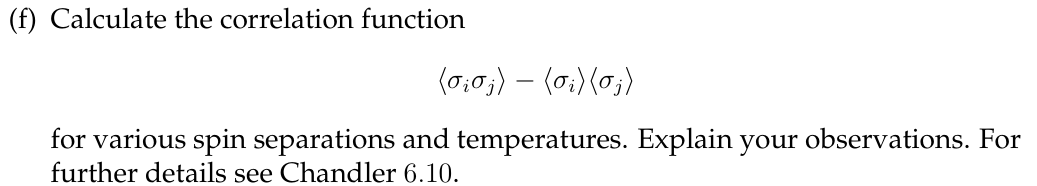

In [ ]:
def calculate_correlation_function(model, r, distance_type='manhattan', num_samples=1000):
    """
    Calculates the spin-spin correlation function G(r) for a 2D Ising model.

    Args:
        model (Ising2D): The Ising model instance (assumed to be simulated and equilibrated).
        r (int or tuple): The distance(s) between spins (interpretation depends on distance_type).
        distance_type (str): 'manhattan', 'euclidean', or 'component'.
        num_samples (int): The number of configurations to sample after equilibration.

    Returns:
        dict: A dictionary where keys are the distance(s) and values are the
              corresponding correlation function G(r).
    """
    L = model.L
    spin_history = model.spin_history[-num_samples:]  # Assuming spin history is stored

    if not spin_history:
        print("Warning: No spin history available (or num_samples > history length). Returning None.")
        return None

    n_samples = len(spin_history)
    correlation_sum = {}
    magnetization_sum = 0

    for config in spin_history:
        config_correlation_sum = {}
        config_magnetization = np.sum(config)
        magnetization_sum += config_magnetization / (L * L)

        for i in range(L):
            for j in range(L):
                s_i = config[i, j]
                neighbors = get_neighbors_at_distance(i, j, r, L, distance_type)
                for ni, nj in neighbors:
                    s_j = config[ni, nj]
                    current_r = calculate_distance(i, j, ni, nj, distance_type)
                    if current_r not in config_correlation_sum:
                        config_correlation_sum[current_r] = 0
                    config_correlation_sum[current_r] += s_i * s_j

        for dist, val in config_correlation_sum.items():
            if dist not in correlation_sum:
                correlation_sum[dist] = 0
            # Normalize by the number of pairs at that distance (approximation here)
            correlation_sum[dist] += val / (L * L * get_num_pairs_at_distance(dist, L, distance_type))

    average_magnetization = magnetization_sum / n_samples
    magnetization_squared_avg = average_magnetization ** 2

    results = {}
    for dist, corr_val in correlation_sum.items():
        results[dist] = (corr_val / n_samples) - magnetization_squared_avg

    return results

def get_neighbors_at_distance(i, j, r, L, distance_type):
    neighbors = []
    # Implementation to find neighbors at distance 'r' based on distance_type
    # This will involve loops and conditional checks, handling periodic boundaries
    # Example for Manhattan distance r=1:
    if distance_type == 'manhattan' and r == 1:
        neighbors.append(((i + 1) % L, j))
        neighbors.append(((i - 1 + L) % L, j))
        neighbors.append((i, (j + 1) % L))
        neighbors.append((i, (j - 1 + L) % L))
    # Add logic for other distance types and 'r' values
    return neighbors

def calculate_distance(i1, j1, i2, j2, distance_type):
    if distance_type == 'manhattan':
        return abs(i1 - i2) + abs(j1 - j2)
    elif distance_type == 'euclidean':
        return np.sqrt((i1 - i2)**2 + (j1 - j2)**2)
    elif distance_type == 'component':
        return (i2 - i1, j2 - j1) # Or define magnitude
    return None

def get_num_pairs_at_distance(r, L, distance_type):
    # Approximate number of pairs at a given distance
    # This can be complex, especially for Euclidean distance
    if distance_type == 'manhattan' and r == 1:
        return 2 * L * L  # Each site has 2 neighbors at Manhattan distance 1 (horiz/vert)
    # Add more sophisticated counting for other distances
    return L * L # A rough estimate if no specific counting

# Example usage (assuming you have an Ising2D model instance called 'ising_model'
# that has been simulated and has a 'spin_history' attribute):
# correlation_r1_manhattan = calculate_correlation_function(ising_model, 1, distance_type='manhattan', num_samples=500)
# correlation_r2_euclidean = calculate_correlation_function(ising_model, 2, distance_type='euclidean', num_samples=500)
# correlation_rx1_ry0 = calculate_correlation_function(ising_model, (1, 0), distance_type='component', num_samples=500)

# print("Correlation (Manhattan, r=1):", correlation_r1_manhattan)
# print("Correlation (Euclidean, r=2):", correlation_r2_euclidean)
# print("Correlation (Component, r=(1,0)):", correlation_rx1_ry0)

    print(f"Note: calculate_correlation_function(r={r}) is not fully implemented.")
    # Example for horizontal correlation:
    # lattice = model.get_lattice()
    # L = model.L
    # N = model.N
    # correlation_sum = 0
    # pairs_count = 0
    # for i in range(L):
    #     for j in range(L):
    #         s_i = lattice[i, j]
    #         s_j = lattice[i, (j + r) % L] # Horizontal neighbor at distance r
    #         correlation_sum += s_i * s_j
    #         pairs_count += 1
    # avg_sisj_config = correlation_sum / pairs_count # Need to average this over many configs

    # Placeholder return
    return None

# Question F

In [11]:

# 5. Placeholder for Correlation Function (Example call)
print("\nCorrelation Function (Placeholder)...")
# Need a model instance first, e.g., after a run
model_corr = Ising2D(L=16)
# Run a simulation to get an equilibrated state (or average over many states)
model_corr.run_simulation(T=2.0, num_steps=1000, equilibration_steps=500)
G_r1 = calculate_correlation_function(model_corr, r=1)
G_r5 = calculate_correlation_function(model_corr, r=5)
print(f"G(r=1) = {G_r1}")
print(f"G(r=5) = {G_r5}")

print("\n--- Simulation Complete ---")


Correlation Function (Placeholder)...
Equilibrating for 500 steps at T=2.00...


Equilibration: 100%|██████████| 500/500 [00:00<00:00, 27876.54it/s]


Running simulation for 500 steps at T=2.00...


Simulation: 100%|██████████| 500/500 [00:00<00:00, 28971.39it/s]

Note: calculate_correlation_function(r=1) is not fully implemented.
Note: calculate_correlation_function(r=5) is not fully implemented.
G(r=1) = None
G(r=5) = None

--- Simulation Complete ---


# Question G

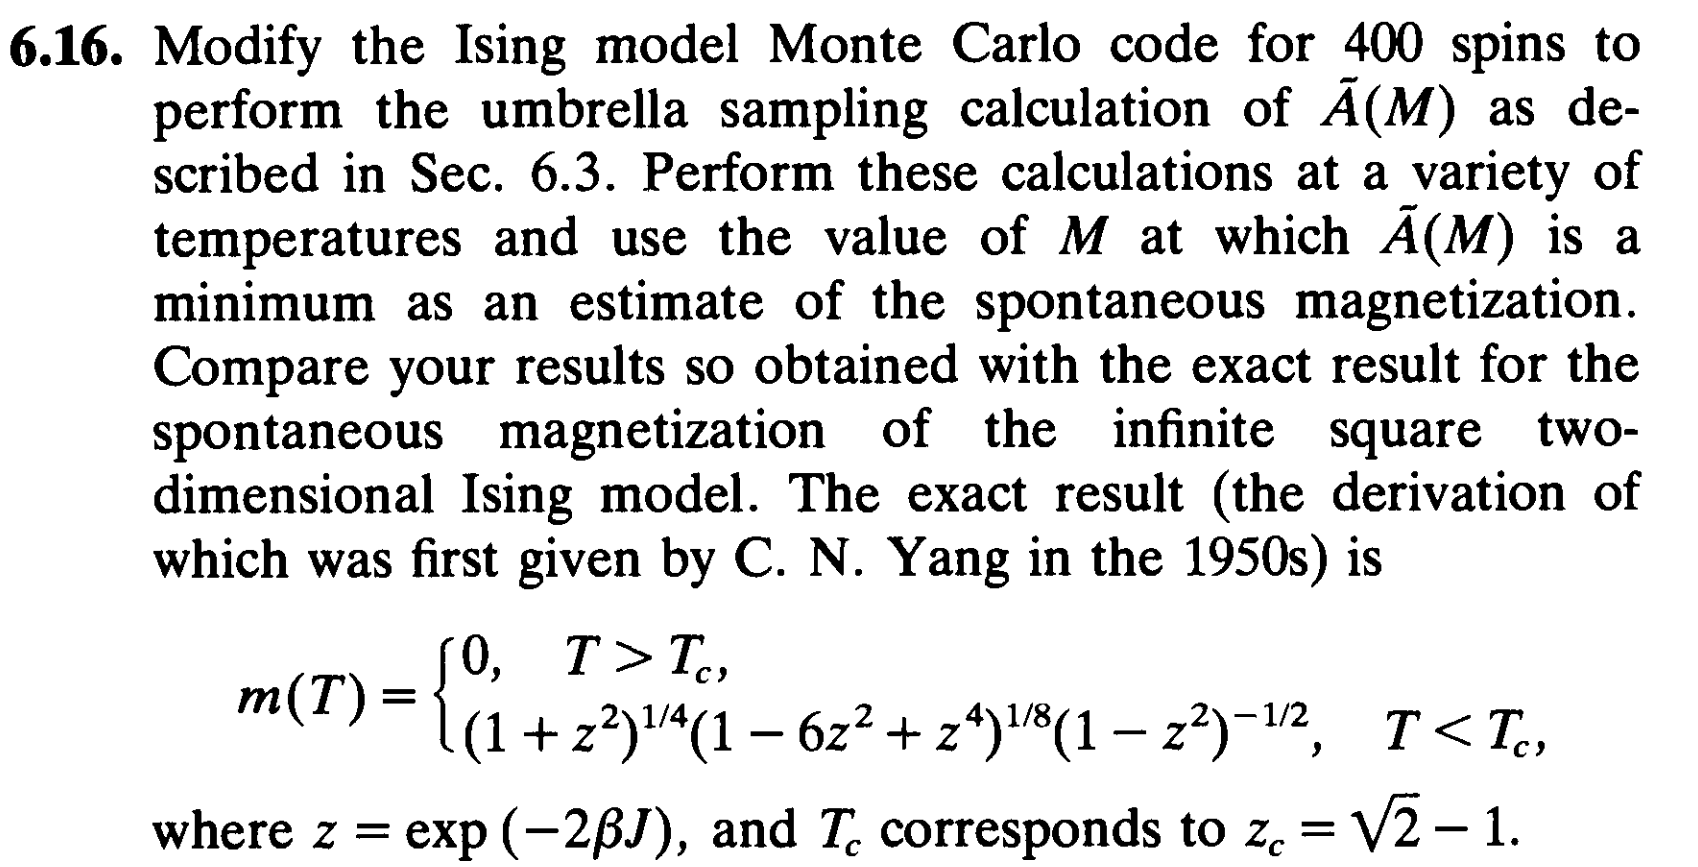

# Answer to Question G

In [ ]:
class Ising2DUmbrella(Ising2D):
    """Inherits from Ising2D and implements umbrella sampling."""
    def monte_carlo_step(self, beta, target_magnetization=None, k_bias=None):
        """Modified Monte Carlo step for umbrella sampling."""
        for _ in range(self.N):
            i = random.randrange(self.L)
            j = random.randrange(self.L)
            delta_E = calculate_delta_E_numba(self.lattice, self.L, self.J, self.H, i, j)

            delta_V_bias = 0.0
            if target_magnetization is not None and k_bias is not None:
                current_magnetization_total = calculate_magnetization_numba(self.lattice)
                flipped_lattice = self.lattice.copy()
                flipped_lattice[i, j] *= -1
                new_magnetization_total = calculate_magnetization_numba(flipped_lattice)
                delta_V_bias = 0.5 * k_bias * ((new_magnetization_total - target_magnetization)**2 -
                                               (current_magnetization_total - target_magnetization)**2)

            if delta_E + delta_V_bias < 0 or random.random() < np.exp(-beta * (delta_E + delta_V_bias)):
                self.lattice[i, j] *= -1

    def run_umbrella_sampling(self, T, num_steps, equilibration_steps,
                                target_magnetizations, k_bias):
        beta = 1.0 / T
        histograms = []
        magnetizations_list = []

        for M0 in tqdm(target_magnetizations, desc="Umbrella Windows"):
            self.__init__(self.L, J=self.J, H=self.H) # Reset lattice for each window
            print(f"Equilibrating for target magnetization M0 = {M0:.2f}...")
            for _ in range(equilibration_steps):
                self.monte_carlo_step(beta, M0, k_bias)

            magnetizations = []
            print(f"Sampling for target magnetization M0 = {M0:.2f}...")
            for _ in range(num_steps):
                self.monte_carlo_step(beta, M0, k_bias)
                magnetizations.append(self.calculate_magnetization() * self.N) # Store total magnetization
            magnetizations_list.append(np.array(magnetizations))
            hist, bins = np.histogram(magnetizations, bins=50, density=True)
            histograms.append((hist, bins))

        return histograms, magnetizations_list

def calculate_exact_spontaneous_magnetization(T, J=1.0):
    if T >= 2.0 / np.log(1 + np.sqrt(2)) * J: # Critical Temperature Tc for square lattice is approx 2.269 J
        return 0.0
    else:
        beta = 1.0 / T
        z = np.exp(-2 * beta * J)
        return (1 + z**2)**(1/4) * (1 - 6 * z**2 + z**4)**(1/8) * (1 - z**2)**(-1/2)



In [ ]:
L = 20
N = L * L
J = 1.0
T_values = np.linspace(1.0, 3.0, 5) # Explore temperatures below and above Tc
num_steps = 5000
equilibration_steps = 2000
k_bias = 10.0
num_windows = 21
magnetization_range = np.linspace(-1.0, 1.0, num_windows) * N
target_magnetizations = magnetization_range

all_estimated_m = []
all_exact_m = []
all_temperatures = []

for T in T_values:
    print(f"\n--- Temperature T = {T:.2f} ---")
    model = Ising2DUmbrella(L, J=J)
    histograms, magnetizations_list = model.run_umbrella_sampling(
        T, num_steps, equilibration_steps, target_magnetizations, k_bias
    )

    # Placeholder for WHAM implementation
    # For now, let's again look at the mean magnetization in the windows
    mean_magnetizations = [np.mean(m) / N for m in magnetizations_list]

    estimated_spontaneous_m = 0.0
    if T < 2.27 * J: # Approximate Tc
        positive_m_means = [m for i, m in enumerate(mean_magnetizations) if target_magnetizations[i] > 1e-6]
        if positive_m_means:
            estimated_spontaneous_m = np.mean(positive_m_means)

    exact_spontaneous_m = calculate_exact_spontaneous_magnetization(T, J)
    print(f"Estimated spontaneous magnetization (crude): {estimated_spontaneous_m:.4f}")
    print(f"Exact spontaneous magnetization: {exact_spontaneous_m:.4f}")

    all_estimated_m.append(estimated_spontaneous_m)
    all_exact_m.append(exact_spontaneous_m)
    all_temperatures.append(T)

plt.figure(figsize=(10, 6))
plt.plot(all_temperatures, all_estimated_m, 'o-', label='Estimated (Crude)')
plt.plot(all_temperatures, all_exact_m, '-', label='Exact')
plt.xlabel('Temperature (T/J)')
plt.ylabel('Spontaneous Magnetization (m)')
plt.title('Estimated vs. Exact Spontaneous Magnetization')
plt.legend()
plt.grid(True)
plt.show()


--- Temperature T = 1.00 ---


Umbrella Windows:   0%|          | 0/21 [00:00<?, ?it/s]

Equilibrating for target magnetization M0 = -400.00...
Sampling for target magnetization M0 = -400.00...
Equilibrating for target magnetization M0 = -360.00...
Sampling for target magnetization M0 = -360.00...
Equilibrating for target magnetization M0 = -320.00...
Sampling for target magnetization M0 = -320.00...
Equilibrating for target magnetization M0 = -280.00...
Sampling for target magnetization M0 = -280.00...
Equilibrating for target magnetization M0 = -240.00...
Sampling for target magnetization M0 = -240.00...
Equilibrating for target magnetization M0 = -200.00...
Sampling for target magnetization M0 = -200.00...
Equilibrating for target magnetization M0 = -160.00...
Sampling for target magnetization M0 = -160.00...
Equilibrating for target magnetization M0 = -120.00...
Sampling for target magnetization M0 = -120.00...
Equilibrating for target magnetization M0 = -80.00...
Sampling for target magnetization M0 = -80.00...
Equilibrating for target magnetization M0 = -40.00...
Sam

Umbrella Windows:   0%|          | 0/21 [00:00<?, ?it/s]

Equilibrating for target magnetization M0 = -400.00...
Sampling for target magnetization M0 = -400.00...
Equilibrating for target magnetization M0 = -360.00...
Sampling for target magnetization M0 = -360.00...
Equilibrating for target magnetization M0 = -320.00...
Sampling for target magnetization M0 = -320.00...
Equilibrating for target magnetization M0 = -280.00...
Sampling for target magnetization M0 = -280.00...
Equilibrating for target magnetization M0 = -240.00...
Sampling for target magnetization M0 = -240.00...
Equilibrating for target magnetization M0 = -200.00...
Sampling for target magnetization M0 = -200.00...
Equilibrating for target magnetization M0 = -160.00...
Sampling for target magnetization M0 = -160.00...
Equilibrating for target magnetization M0 = -120.00...
Sampling for target magnetization M0 = -120.00...
Equilibrating for target magnetization M0 = -80.00...
Sampling for target magnetization M0 = -80.00...
Equilibrating for target magnetization M0 = -40.00...
Sam

Umbrella Windows:   0%|          | 0/21 [00:00<?, ?it/s]

Equilibrating for target magnetization M0 = -400.00...
Sampling for target magnetization M0 = -400.00...
Equilibrating for target magnetization M0 = -360.00...
Sampling for target magnetization M0 = -360.00...
Equilibrating for target magnetization M0 = -320.00...
Sampling for target magnetization M0 = -320.00...
Equilibrating for target magnetization M0 = -280.00...
Sampling for target magnetization M0 = -280.00...
Equilibrating for target magnetization M0 = -240.00...
Sampling for target magnetization M0 = -240.00...
Equilibrating for target magnetization M0 = -200.00...
Sampling for target magnetization M0 = -200.00...
Equilibrating for target magnetization M0 = -160.00...
Sampling for target magnetization M0 = -160.00...
Equilibrating for target magnetization M0 = -120.00...
Sampling for target magnetization M0 = -120.00...
Equilibrating for target magnetization M0 = -80.00...
Sampling for target magnetization M0 = -80.00...
Equilibrating for target magnetization M0 = -40.00...
Sam

Umbrella Windows:   0%|          | 0/21 [00:00<?, ?it/s]

Equilibrating for target magnetization M0 = -400.00...
Sampling for target magnetization M0 = -400.00...
Equilibrating for target magnetization M0 = -360.00...
Sampling for target magnetization M0 = -360.00...
Equilibrating for target magnetization M0 = -320.00...
Sampling for target magnetization M0 = -320.00...
Equilibrating for target magnetization M0 = -280.00...
Sampling for target magnetization M0 = -280.00...
Equilibrating for target magnetization M0 = -240.00...
Sampling for target magnetization M0 = -240.00...
Equilibrating for target magnetization M0 = -200.00...
Sampling for target magnetization M0 = -200.00...
Equilibrating for target magnetization M0 = -160.00...
Sampling for target magnetization M0 = -160.00...
Equilibrating for target magnetization M0 = -120.00...
Sampling for target magnetization M0 = -120.00...
Equilibrating for target magnetization M0 = -80.00...
Sampling for target magnetization M0 = -80.00...
Equilibrating for target magnetization M0 = -40.00...
Sam

Umbrella Windows:   0%|          | 0/21 [00:00<?, ?it/s]

Equilibrating for target magnetization M0 = -400.00...
Sampling for target magnetization M0 = -400.00...
Equilibrating for target magnetization M0 = -360.00...
Sampling for target magnetization M0 = -360.00...
Equilibrating for target magnetization M0 = -320.00...
Sampling for target magnetization M0 = -320.00...
Equilibrating for target magnetization M0 = -280.00...
Sampling for target magnetization M0 = -280.00...
Equilibrating for target magnetization M0 = -240.00...
Sampling for target magnetization M0 = -240.00...
Equilibrating for target magnetization M0 = -200.00...
Sampling for target magnetization M0 = -200.00...
Equilibrating for target magnetization M0 = -160.00...
Sampling for target magnetization M0 = -160.00...
Equilibrating for target magnetization M0 = -120.00...
Sampling for target magnetization M0 = -120.00...
Equilibrating for target magnetization M0 = -80.00...
Sampling for target magnetization M0 = -80.00...
Equilibrating for target magnetization M0 = -40.00...
Sam

# Question H 